# Data Processing for Finding UCDs in Deep Surveys

In [1]:
#imports

# std lib
from getpass import getpass

# standard
import numpy as np
import pylab as plt
import matplotlib
%matplotlib inline
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.lines as mlines
import pandas as pd
from numpy.polynomial import polynomial as P

# Data Lab
from dl import authClient as ac, queryClient as qc, storeClient as sc

# machine learning
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, classification_report, PrecisionRecallDisplay, RocCurveDisplay, f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold,RepeatedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.calibration import calibration_curve

# others
from dl.helpers.utils import convert
import os
import warnings
from pathlib import Path
from typing import Iterable, List, Optional, Union
import seaborn as sns

In [2]:
# Login for Astro Data Lab

token = ac.login(input("Enter user name: (+ENTER) "),getpass("Enter password: (+ENTER) "))

Enter user name: (+ENTER)  malinadesai
Enter password: (+ENTER)  ·········


### Using the Ultracool Sheet

The Ultracool Sheet (Best et al. 2020) contains the coordinates, photometry, spectral types, and proper motions of known ultracool dwarfs (UCDs). The coordinates used in many surveys are IRCS coordinates from the J200 epoch, which are found in the Ultracool Sheet as ra_j2000_formula and dec_j2000_formula. The best proper motions are given by the 'pmra_formula' and 'pmdec_formula' columns. For this project, r, i, z, and y Pan-STARRS1 (Chambers et al. 2016) photometry are used along with the J, H, and Ks photometry from 2MASS (Skrutskie et al. 2006) and the W1 and W2 photometry from AllWISE (Cutri et al. 2013), with uncertianties for all bands. The 'multiple_unresolved_in_this_table' column states whether a source has a known companion. The spectral type used is the absolute value of the numerical spectral type, so no distinction between dwarfs and subdwarfs is made. The Ultracool Sheet uses optical types for M and L dwarfs and near-infrared types for T dwarfs when both types are available. 

In [227]:
# Importing the UltracoolSheet

sc.put('/Users/malina/Downloads/UltracoolSheet.xlsx','vos://UltracoolSheet')
ultracoolsheet = pd.read_excel(io = r'UltracoolSheet.xlsx', sheet_name = 'Main')

In [231]:
# getting desired columns from the UltracoolSheet

ucs = ultracoolsheet[['name', 'ra_j2000_formula', 'dec_j2000_formula', 'pmra_formula', 'pmdec_formula', \
                      'r_P1', 'i_P1', 'z_P1', 'y_P1', 'rerr_P1', 'ierr_P1', 'zerr_P1', 'yerr_P1', 'J_2MASS', \
                      'H_2MASS', 'Ks_2MASS', 'Jerr_2MASS', 'Herr_2MASS', 'Kserr_2MASS','W1', 'W2', 'W1err', \
                      'W2err', 'multiple_unresolved_in_this_table', 'sptnumabs_formula' \
                     ]].copy()


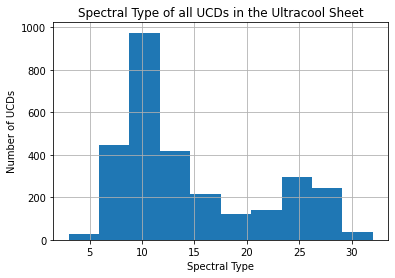

In [5]:
# checking the spectral type

plt.hist(ucs['sptnumabs_formula'])
plt.xlabel('Spectral Type')
plt.ylabel('Number of UCDs')
plt.title('Spectral Type of all UCDs in the Ultracool Sheet')
plt.grid()


In [6]:
# see what photometry the T dwarfs have: there are 0 T dwarfs with PS1 r-band photometry, and only 17 with i-band.

tdwarfs = ucs.loc[ucs['sptnumabs_formula'] >= 20]
tdwarfs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 738 entries, 0 to 2938
Data columns (total 25 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   name                               738 non-null    object 
 1   ra_j2000_formula                   738 non-null    float64
 2   dec_j2000_formula                  738 non-null    float64
 3   pmra_formula                       659 non-null    float64
 4   pmdec_formula                      659 non-null    float64
 5   r_P1                               0 non-null      float64
 6   i_P1                               17 non-null     float64
 7   z_P1                               276 non-null    float64
 8   y_P1                               377 non-null    float64
 9   rerr_P1                            0 non-null      float64
 10  ierr_P1                            17 non-null     float64
 11  zerr_P1                            276 non-null    float6

In [7]:
# convert proper motions from milliarcseconds/yr to arcseconds/yr

ucs['pmra_formula'] = ucs['pmra_formula'].apply(lambda x: x * 0.001)
ucs['pmdec_formula'] = ucs['pmdec_formula'].apply(lambda x: x * 0.001)

In [8]:
# change some column names for ease of use

ucs = ucs.rename(columns = {'multiple_unresolved_in_this_table':'binary', \
                            'pmra_formula':'ucs_pmra', 'pmdec_formula':'ucs_pmdec', \
                            'ra_j2000_formula':'ucs_ra', \
                            'dec_j2000_formula':'ucs_dec', \
                            'sptnumabs_formula':'spectral_type' \
                            })

In [9]:
# functions

def sigma_2d(first_array, second_array):
    '''
    Calculates the standard deviation of two arrays, adds them in quadrature, and returns the 
    2 dimensional standard deviation
    first_array   :  first array containing the data
    second_array  :  second array containing the data
    '''
        
    # calculate the mean and standard devation for 2 dimensional data
    sigma_init1 = first_array.std()
    sigma_init2 = second_array.std()
    sigma_init_tot = np.sqrt(sigma_init1**2 + sigma_init2**2)
    
    return sigma_init_tot

def stats_func_1d(array, df, spreadlim, col_name):
    '''
    Processes a dataframe column and returns the average, standard deviation, and 3 sigma flags of that column
    array      :  array containing the data
    df         :  dataframe containing the data
    spreadlim  :  cutoff for outliers
    col_name   :  name of the dataframe column containing the data
    '''
    
    # get rid of outliers by calculating spread up to one standard deviation of the data
    array = [x for x in array if (x <= spreadlim and x >= -spreadlim)]
    array = np.asarray(array)
    
    # cacluate the new means and standard deviations on smaller spread
    mu = array.mean()
    sigma = array.std()
    
    # setting ra and dec boundaries at 3 sigma
    upper_bound, lower_bound = mu + 3*sigma, mu - 3*sigma
    sigma_flag = []

    for i in range(len(df)):
        if df.iloc[i, df.columns.get_loc(col_name)] >= upper_bound:     
            sigma_flag.append(True)
        elif df.iloc[i, df.columns.get_loc(col_name)] <= lower_bound:
            sigma_flag.append(True)
        else:
            sigma_flag.append(False)
    
    return mu, sigma, sigma_flag

def stats_func_2d(first_array, second_array, df, spreadlim, first_col, second_col):
    '''
    Processes two dataframe columns and returns the average, standard deviation, and 3 sigma flags
    of the two-dimensional spread of data. Automatically takes the combined 3 sigma of the spread as 
    the outlier cutoff.
    first_array   :  first array containing the data
    second_array  :  second array containing the data
    df            :  dataframe containing the data
    spreadlim     :  cutoff for outliers, default is 1 standard deviation of the data
    first_col     :  name of the dataframe column containing the data
    second_col    :  name of the dataframe column containing the data
    '''
    
    # get rid of outliers in the data
    first_array = [x for x in first_array if (x <= spreadlim and x >= -spreadlim)]
    first_array= np.asarray(first_array)
    second_array = [x for x in second_array if (x <= spreadlim and x >= -spreadlim)]
    second_array = np.asarray(second_array)
    
    # cacluate the new means and standard deviations on smaller spread
    mu_fin1 = first_array.mean()
    mu_fin2 = second_array.mean()
    sigma_fin1 = first_array.std()
    sigma_fin2 = second_array.std()
    sigma_tot = np.sqrt(sigma_fin1**2 + sigma_fin2**2)
    
    # setting ra and dec boundaries at 3 sigma
    upper_1, lower_1 = mu_fin1 + 3*sigma_tot, mu_fin1 - 3*sigma_tot
    upper_2, lower_2 = mu_fin2 + 3*sigma_tot, mu_fin2 - 3*sigma_tot
    sigma_flag = []

    # flagging 3 sigma outliers
    for i in range(len(df)):
        if df.iloc[i, df.columns.get_loc(first_col)] >= upper_1:       
            sigma_flag.append(True)
        elif df.iloc[i, df.columns.get_loc(second_col)] >= upper_2:   
            sigma_flag.append(True)
        elif df.iloc[i, df.columns.get_loc(first_col)] <= lower_1:
            sigma_flag.append(True)
        elif df.iloc[i, df.columns.get_loc(second_col)] <= lower_2:
            sigma_flag.append(True)
        else:
            sigma_flag.append(False)
    
    return sigma_tot, sigma_flag



# Matching the Ultracool Sheet to Deep Sky Surveys
The Astro Data Lab Query Interface can be used by making SQL queries through the queryClient module, imported here as qc. The q3c_radial_query module takes 5 inputs: 

table ra - the desired ra columm from the table you are querying \
table dec - the desired dec column from the table you are querying \
search ra - ra around which you would like to search \
search dec - dec around which you would like to search \
radius - the search radius 

with all parameters in degrees. You can order results by radial distance from your desired search coordinates using the q3c_dist command, which takes the same first 4 inputs that q3c_radial_query takes. Lastly, you can crossmatch using q3c_join, which takes 5 inputs: 

table 1 ra - the desired ra columm from the first table you are querying from \
table 1 dec - the desired dec column from the first table you are querying from \
table 2 ra - the desired ra columm from the second table you are querying from \
table 2 dec - the desired dec column from the second table you are querying from \
radius - the allotted search radius for matches between the two coordinates

again, with all parameters in degrees.

More information and examples on queries through Astro Data Lab can be found at: https://datalab.noirlab.edu/docs/manual/Appendices/ExampleQueries/ExampleQueries.html. 

## The Dark Energy Survey (DES)
The Dark Energy Survey (DES, The Dark Energy Survey Collaboration, (2005)), is a catalogue that covers 5,000 square degrees in the Southern Hemisphere in the g, r, i, z, and Y bands. Below, we match the stars in the Ultracool Sheet with DES through coordinate-based matching with the des_dr2.main table. The columns used are the j2000 ra and dec and the psf r, i, z, and Y bands along with their uncertainties. The queries use certain flags to account for quality and object type. They are listed below:

EXTENDED_CLASS_COADD - identifies if the source is likely a star or a galaxy, with <= 1 for stellar and >=2 for galactic \
IMAFLAGS_ISO_I - identifies missing/bad pixels in the i band \
IMAFLAGS_ISO_Z - identifies missing/bad pixels in the z band \
FLAGS_I - identifies objects that may not have been extracted well in the i band, set to < 4 for well-behaved objects \
FLAGS_Z - identifies objects that may not have been extracted well in the z band, set to < 4 for well-behaved objects 

Additionally, a color cut is made for i-z >= 1 for finding UCDs. 

In [10]:
# finds all UC Stars with an ra/dec that returns a DES query result

insearch = []
ra_list = []
dec_list = []
radius = 0.007

for i in range(len(ucs)):
    ra0 = ucs.iloc[i, 1]  # in degrees, right ascension
    ra_list.append(ra0)
    dec0 = ucs.iloc[i, 2] # in degrees, declinarion
    dec_list.append(dec0)
    query = """
    SELECT ra, dec, wavg_mag_psf_r, wavg_mag_psf_i, wavg_mag_psf_z, wavg_mag_psf_y FROM des_dr2.main as dr2,
    q3c_dist(ra, dec, {:f}, {:f}) as rdist
      WHERE dr2.EXTENDED_CLASS_COADD <= 1
        AND dr2.IMAFLAGS_ISO_I = 0
        AND dr2.IMAFLAGS_ISO_Z = 0
        AND dr2.FLAGS_I < 4 
        AND dr2.FLAGS_Z < 4
        AND (dr2.MAG_AUTO_I - dr2.MAG_AUTO_Z >= 1 or dr2.WAVG_MAG_PSF_I - dr2.WAVG_MAG_PSF_Z >= 1)
        AND q3c_radial_query(ra,dec,{:f},{:f},{:f})
    order by rdist
    """.format(ra0,dec0,ra0,dec0,radius)
    response = qc.query(sql=query,format='csv')
    sources = convert(response,'pandas')
    if len(sources) >= 1:   # need at least one result 
        insearch.append(True)
    else:
        insearch.append(False)


In [11]:
# create a true/false column with the search results

ucs['DES_Search'] = np.array(insearch)

In [12]:
# take only the columns labelled with 'true' to get all potential matches

des_search = ucs.loc[ucs['DES_Search']==True]
des_search = des_search.reset_index(drop=True)
des_search

,name,ucs_ra,ucs_dec,ucs_pmra,ucs_pmdec,r_P1,i_P1,z_P1,y_P1,rerr_P1,...,Jerr_2MASS,Herr_2MASS,Kserr_2MASS,W1,W2,W1err,W2err,binary,spectral_type,DES_Search
0,2MASS J00040288-6410358,1.0127,-64.1768,0.06400,-0.04700,NaN,NaN,NaN,NaN,NaN,...,0.072,0.046,0.046,13.409,12.959,0.024,0.026,N,11.0,True
1,DENIS J0006579-643654,1.7414,-64.6151,0.08690,-0.06170,NaN,NaN,NaN,NaN,NaN,...,0.026,0.033,0.033,11.741,11.421,0.022,0.021,N,10.0,True
2,ULAS J000734.90+011247.1,1.8957,1.2132,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,17.289,15.874,0.165,0.187,N,27.0,True
3,ULAS J001040.57+010013.1,2.6688,1.0039,0.04700,-0.06600,NaN,NaN,20.71,19.99,NaN,...,NaN,NaN,NaN,16.526,16.227,0.085,0.237,N,11.0,True
4,2MASS J00145575-4844171,3.7324,-48.7380,0.87073,0.28150,NaN,NaN,NaN,NaN,NaN,...,0.035,0.030,0.030,12.267,11.987,0.023,0.022,N,12.5,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,SDSS J234841.38-004022.1,357.1724,-0.6727,0.09200,-0.10600,NaN,21.82,20.29,19.32,NaN,...,NaN,NaN,NaN,16.069,16.156,0.074,0.284,N,11.5,True
298,WISE J235425.33-564928.6,358.6058,-56.8247,0.39000,-0.33000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,16.835,14.872,0.081,0.054,N,26.0,True
299,ULAS J235715.98+013240.3,359.3166,1.5445,0.04700,0.00100,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,25.5,True
300,SDSS J235835.45-000909.5,359.6478,-0.1526,-0.09700,-0.22900,NaN,21.09,19.55,18.73,NaN,...,0.190,0.245,NaN,NaN,NaN,NaN,NaN,N,10.0,True


In [13]:
# takes the 302 stars in DES field and matches them to DES query

des_query = pd.DataFrame()
no_of_matches = []

for i in range(len(des_search)):
    ra0 = des_search.iloc[i, 1] # in degrees, right ascension
    dec0 = des_search.iloc[i, 2] # in degrees, declinarion
    names = des_search.iloc[i, 0] # unique object identifier
    query = """
    SELECT ra, dec, wavg_mag_psf_r, wavg_mag_psf_i, wavg_mag_psf_z, wavg_mag_psf_y, wavg_magerr_psf_r, wavg_magerr_psf_i, wavg_magerr_psf_z, wavg_magerr_psf_y
    FROM des_dr2.main as dr2,
    q3c_dist(ra, dec, {:f}, {:f}) as rdist
      WHERE dr2.EXTENDED_CLASS_COADD <= 1
        AND dr2.IMAFLAGS_ISO_I = 0
        AND dr2.IMAFLAGS_ISO_Z = 0
        AND dr2.FLAGS_I < 4 
        AND dr2.FLAGS_Z < 4
        AND (dr2.MAG_AUTO_I - dr2.MAG_AUTO_Z >= 1 or dr2.WAVG_MAG_PSF_I - dr2.WAVG_MAG_PSF_Z >= 1)
        AND q3c_radial_query(ra,dec,{:f},{:f},{:f})
    order by rdist
    """.format(ra0,dec0,ra0,dec0,radius)
    response = qc.query(sql=query,format='csv')
    sources = convert(response,'pandas')
    sources['ra_comp'] = (sources['ra'] - ra0) * np.cos(dec0 * (np.pi / 180))       # difference in right ascension  
    sources['dec_comp'] = sources['dec'] - dec0                                     # difference in declination
    closestmatch = sources.copy()
    closestmatch = closestmatch.head(1)
    closestmatch['name'] = names
    no_of_matches.append(len(sources))
    des_query = pd.concat([des_query, closestmatch], ignore_index = True)


In [14]:
# displaying the output of the matches found

des_query

,ra,dec,wavg_mag_psf_r,wavg_mag_psf_i,wavg_mag_psf_z,wavg_mag_psf_y,wavg_magerr_psf_r,wavg_magerr_psf_i,wavg_magerr_psf_z,wavg_magerr_psf_y,ra_comp,dec_comp,name
0,1.012803,-64.176876,22.338305,20.059380,18.519573,17.932535,0.022949,0.005091,0.002203,0.005818,0.000045,-0.000076,2MASS J00040288-6410358
1,1.742311,-64.615360,19.942392,17.264570,15.659860,15.111554,0.003207,0.000811,0.000423,0.000699,0.000391,-0.000260,DENIS J0006579-643654
2,1.895924,1.213136,-99.000000,-99.000000,21.823662,20.577265,-99.000000,-99.000000,0.034881,0.042860,0.000224,-0.000064,ULAS J000734.90+011247.1
3,2.666957,1.005466,24.037722,23.675348,-99.000000,-99.000000,0.251121,0.285420,-99.000000,-99.000000,-0.001843,0.001566,ULAS J001040.57+010013.1
4,3.735926,-48.737337,23.668186,23.184174,-99.000000,-99.000000,0.069855,0.091890,-99.000000,-99.000000,0.002325,0.000663,2MASS J00145575-4844171
...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,357.173019,-0.668376,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,0.000619,0.004324,SDSS J234841.38-004022.1
298,358.606541,-56.824933,-99.000000,-99.000000,20.677748,19.547394,-99.000000,-99.000000,0.018851,0.021544,0.000405,-0.000233,WISE J235425.33-564928.6
299,359.316761,1.544574,-99.000000,-99.000000,22.119720,21.036600,-99.000000,-99.000000,0.047793,0.070025,0.000161,0.000074,ULAS J235715.98+013240.3
300,359.647526,-0.154361,24.022510,23.454973,-99.000000,-99.000000,0.246901,0.211333,-99.000000,-99.000000,-0.000274,-0.001761,SDSS J235835.45-000909.5


In [15]:
# combining the DES data with the Ultracool Sheet data
des_mags = pd.merge(des_query, des_search, how = 'inner', on = 'name')

# placing -99's as NaN's
des_mags = des_mags.replace(-99.0, np.NaN)

# difference in magnitudes
des_mags['r_diff'] = des_mags['r_P1'] - des_mags['wavg_mag_psf_r']
des_mags['i_diff'] = des_mags['i_P1'] - des_mags['wavg_mag_psf_i']
des_mags['z_diff'] = des_mags['z_P1'] - des_mags['wavg_mag_psf_z']
des_mags['y_diff'] = des_mags['y_P1'] - des_mags['wavg_mag_psf_y']

des_mags

,ra,dec,wavg_mag_psf_r,wavg_mag_psf_i,wavg_mag_psf_z,wavg_mag_psf_y,wavg_magerr_psf_r,wavg_magerr_psf_i,wavg_magerr_psf_z,wavg_magerr_psf_y,...,W2,W1err,W2err,binary,spectral_type,DES_Search,r_diff,i_diff,z_diff,y_diff
0,1.012803,-64.176876,22.338305,20.059380,18.519573,17.932535,0.022949,0.005091,0.002203,0.005818,...,12.959,0.024,0.026,N,11.0,True,NaN,NaN,NaN,NaN
1,1.742311,-64.615360,19.942392,17.264570,15.659860,15.111554,0.003207,0.000811,0.000423,0.000699,...,11.421,0.022,0.021,N,10.0,True,NaN,NaN,NaN,NaN
2,1.895924,1.213136,NaN,NaN,21.823662,20.577265,NaN,NaN,0.034881,0.042860,...,15.874,0.165,0.187,N,27.0,True,NaN,NaN,NaN,NaN
3,2.666957,1.005466,24.037722,23.675348,NaN,NaN,0.251121,0.285420,NaN,NaN,...,16.227,0.085,0.237,N,11.0,True,NaN,NaN,NaN,NaN
4,3.735926,-48.737337,23.668186,23.184174,NaN,NaN,0.069855,0.091890,NaN,NaN,...,11.987,0.023,0.022,N,12.5,True,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,357.173019,-0.668376,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.156,0.074,0.284,N,11.5,True,NaN,NaN,NaN,NaN
298,358.606541,-56.824933,NaN,NaN,20.677748,19.547394,NaN,NaN,0.018851,0.021544,...,14.872,0.081,0.054,N,26.0,True,NaN,NaN,NaN,NaN
299,359.316761,1.544574,NaN,NaN,22.119720,21.036600,NaN,NaN,0.047793,0.070025,...,NaN,NaN,NaN,N,25.5,True,NaN,NaN,NaN,NaN
300,359.647526,-0.154361,24.022510,23.454973,NaN,NaN,0.246901,0.211333,NaN,NaN,...,NaN,NaN,NaN,N,10.0,True,NaN,-2.364973,NaN,NaN


### Identifying Positional and Photometric Outliers

Positional outliers are found in two ways: using the difference in coordinates from the Ultracool Sheet to DES, and by calculating the angular separation of the pair of coordinates. For the DES sample, positional outliers are found through the following mathematical process: First, We calculate the 2-dimensional standard deviation of the difference in right ascension and the difference in declination, which provides us with 12 arcseconds. A subset of one sigma of the two differences is taken and the 2 dimensional standard deviation is re-calculated. We retain 3 sigma of this new standard deviation. For the angular separation, a cutoff is set to 16 arcseconds and the standard deviation of angular separation is calculated. We retain 3 sigma of the angular separation. 

The outlier process is consistent across all photometric bands. The difference in magnitude from PS1 to DES is calculated. A cutoff of 1 magnitude is set, where all differences less than 1 are taken. The standard deviation of this subsample is calculated. We retain all samples within 3 sigma of this standard deviation. 

In [16]:
# converting difference between coordinates to arc seconds

des_mags['dec_comp'] = des_mags['dec_comp'].apply(lambda x: x*3600)
des_mags['ra_comp'] = des_mags['ra_comp'].apply(lambda x: x*3600)

In [17]:
# finding the high proper motion objects - top 20
highpmra = des_mags.reindex(des_mags.ucs_pmra.abs().sort_values(ascending = False).index).head(20)
highpmdec = des_mags.reindex(des_mags.ucs_pmdec.abs().sort_values(ascending = False).index).head(20)

# finding the unresolved binary objects - 16 total
binaries = des_mags[des_mags.binary != 'N']

In [18]:
# flag 3 sigma outliers
sigma_init = sigma_2d(des_mags['ra_comp'].to_numpy(), des_mags['dec_comp'].to_numpy())
sigma_pos, sigma_flag = stats_func_2d(des_mags['ra_comp'].to_numpy(), des_mags['dec_comp'].to_numpy(), des_mags, \
                                      sigma_init, 'ra_comp', 'dec_comp')

# adding a flag to the dataframe
des_mags['sigma_3'] = np.array(sigma_flag)
des_mags_3sigma = des_mags.loc[des_mags['sigma_3']==True]
len(des_mags_3sigma)

27

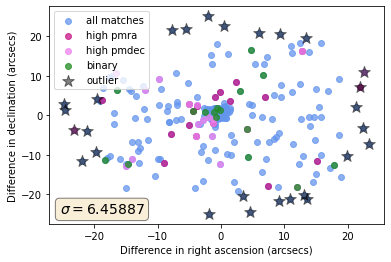

In [19]:
# plot separation in right ascention and declination for closest coordinate matches

textstr = ''r'$\sigma=%.5f$' % (sigma_pos, )

plt.scatter(des_mags['dec_comp'].values, des_mags['ra_comp'].values, alpha = 0.75, color = 'cornflowerblue', label = 'all matches')
plt.scatter(highpmra['dec_comp'].values, highpmra['ra_comp'].values, alpha = 0.75, color = 'mediumvioletred', label = 'high pmra')
plt.scatter(highpmdec['dec_comp'].values, highpmdec['ra_comp'].values, alpha = 0.75, color = 'violet', label = 'high pmdec')
plt.scatter(binaries['dec_comp'].values, binaries['ra_comp'].values, alpha = 0.75, color = 'forestgreen', label = 'binary')
plt.scatter(des_mags_3sigma['dec_comp'].values, des_mags_3sigma['ra_comp'].values, 150, alpha = 0.5, \
            color = 'k', marker= '*', label = 'outlier')
plt.ylabel('Difference in declination (arcsecs)')
plt.xlabel('Difference in right ascension (arcsecs)')
#plt.title('Coordinate Accuracy Between DES and UltracoolSheet ', fontsize = 15)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(-25.5, -22, textstr, fontsize=14, verticalalignment='top', bbox=props)
plt.legend()
plt.savefig('coordaccuracydesucs.png')

In [20]:
# need to convert to radians from degrees (1" × π/(180))

des_mags['ra'] = des_mags['ra'].apply(lambda x: x * (np.pi/180))
des_mags['dec'] = des_mags['dec'].apply(lambda x: x * (np.pi/180))
des_mags['ucs_ra'] = des_mags['ucs_ra'].apply(lambda x: x * (np.pi/180))
des_mags['ucs_dec'] = des_mags['ucs_dec'].apply(lambda x: x * (np.pi/180))

In [21]:
# calculate angular separation

ang_dis_list = []

for i in range(len(des_mags)):
    ra_des = des_mags.iloc[i, 0]      # in radians, right ascension of DES
    dec_des = des_mags.iloc[i, 1]     # in radians, declinarion of DES
    ra_ucs = des_mags.iloc[i, 13]     # in radians, declinarion of UCS
    dec_ucs = des_mags.iloc[i, 14]    # in radians, declinarion of UCS
    ang_dis = np.arccos(np.sin(dec_ucs)*np.sin(dec_des) + np.cos(dec_ucs)*np.cos(dec_des)*np.cos(ra_ucs - ra_des))
    ang_dis_list.append(ang_dis)

des_mags['angular_sep'] = np.array(ang_dis_list)

# convert angular separation from radians to arcseconds
des_mags['angular_sep'] = des_mags['angular_sep'].apply(lambda x: x * (648000/ np.pi))

# convert ra, and dec from radians back to degrees
des_mags['ucs_dec'] = des_mags['ucs_dec'].apply(lambda x: x * (180/ np.pi))
des_mags['ucs_ra'] = des_mags['ucs_ra'].apply(lambda x: x * (180/ np.pi))
des_mags['dec'] = des_mags['dec'].apply(lambda x: x * (180/ np.pi))
des_mags['ra'] = des_mags['ra'].apply(lambda x: x * (180/ np.pi))

In [22]:
# flag 3 sigma outliers for angular separation:

mu_ang, sigma_ang, sigma_flag = stats_func_1d(des_mags['angular_sep'].to_numpy(), des_mags, \
                                      16, 'angular_sep')
des_mags['sigma_3ang'] = np.array(sigma_flag)
des_mags_3sigma_ang = des_mags.loc[des_mags['sigma_3ang']==True]
len(des_mags_3sigma_ang)

49

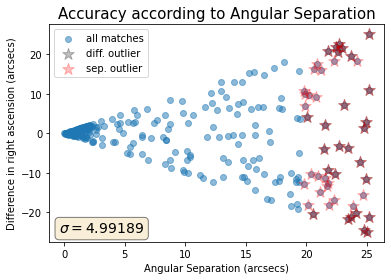

In [23]:
# plot separation in right ascention and declination for closest coordinate matches

des_mags_3sigma = des_mags.loc[des_mags['sigma_3']==True]

textstr = ''r'$\sigma=%.5f$' % (sigma_ang, )

plt.scatter(des_mags['angular_sep'].values, des_mags['ra_comp'].values, alpha = 0.5, label = 'all matches')
plt.scatter(des_mags_3sigma['angular_sep'].values, des_mags_3sigma['ra_comp'].values, 150, alpha = 0.25, \
            color = 'k', marker= '*', label = 'diff. outlier')
plt.scatter(des_mags_3sigma_ang['angular_sep'].values, des_mags_3sigma_ang['ra_comp'].values, 150, alpha = 0.25, \
            color = 'r', marker= '*', label = 'sep. outlier')
plt.xlabel('Angular Separation (arcsecs)')
plt.ylabel('Difference in right ascension (arcsecs)')
plt.title('Accuracy according to Angular Separation', fontsize = 15)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(-0.4, -22.3, textstr, fontsize=14, verticalalignment='top', bbox=props)
plt.legend()

In [24]:
# comparing DES magnitudes to the original ones in the sheet - there are very few objects with complete data, most in the z-band, y-band

comparisonmags_z = des_mags.copy()
comparisonmags_z = comparisonmags_z[comparisonmags_z['z_diff'].notna()]
len(comparisonmags_z)

76

In [25]:
# flag 3 sigma

mu_z, sigma_z, sigma_flag = stats_func_1d(comparisonmags_z['z_diff'].to_numpy(), comparisonmags_z, 1, 'z_diff')

comparisonmags_z['sigma_3z'] = np.array(sigma_flag)
comparisonmags_z_3sigmaz = comparisonmags_z.loc[comparisonmags_z['sigma_3z']==True]
len(comparisonmags_z_3sigmaz)

6

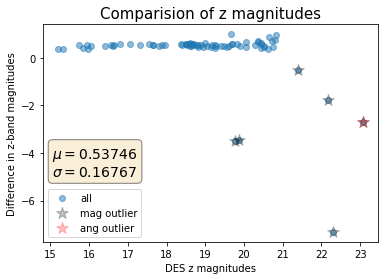

In [26]:
# compare z-band magnitudes from UCS with DES

comparisonmags_z_3sigmaang = comparisonmags_z.loc[comparisonmags_z['sigma_3ang']==True]

y = comparisonmags_z['z_diff']
x = comparisonmags_z['wavg_mag_psf_z']

textstr = '\n'.join((
    r'$\mu=%.5f$' % (mu_z, ),
    r'$\sigma=%.5f$' % (sigma_z, )))

plt.xlabel('DES z magnitudes')
plt.ylabel('Difference in z-band magnitudes')
plt.title('Comparision of z magnitudes', fontsize = 15)
plt.scatter(x, y, alpha = 0.5, label = 'all')
plt.scatter(comparisonmags_z_3sigmaz['wavg_mag_psf_z'].values, comparisonmags_z_3sigmaz['z_diff'].values, 150, alpha = 0.25, \
            color = 'k', marker= '*', label = 'mag outlier')
plt.scatter(comparisonmags_z_3sigmaang['wavg_mag_psf_z'].values, comparisonmags_z_3sigmaang['z_diff'].values, 150, alpha = 0.25, \
            color = 'r', marker= '*', label = 'ang outlier')
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(15.05, -3.7, textstr, fontsize=14, verticalalignment='top', bbox=props)
plt.legend()

In [27]:
# comparing DES magnitudes to the original ones in the sheet - i band

comparisonmags_i = des_mags.copy()
comparisonmags_i = comparisonmags_i[comparisonmags_i['i_diff'].notna()]
len(comparisonmags_i)

76

In [28]:
# flag 3 sigma

mu_i, sigma_i, sigma_flag = stats_func_1d(comparisonmags_i['i_diff'].to_numpy(), comparisonmags_i, 1, 'i_diff')

comparisonmags_i['sigma_3i'] = np.array(sigma_flag)
comparisonmags_i_3sigma = comparisonmags_i.loc[comparisonmags_i['sigma_3i']==True]
len(comparisonmags_i_3sigma)

13

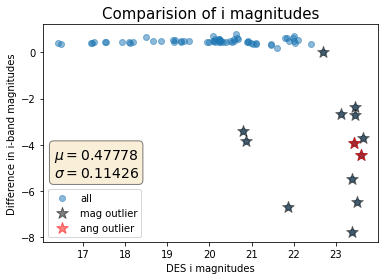

In [29]:
# compare i-band magnitudes from UCS with DES

comparisonmags_i_3sigma_ang = comparisonmags_i.loc[comparisonmags_i['sigma_3ang']==True]

y = comparisonmags_i['i_diff']
x = comparisonmags_i['wavg_mag_psf_i']

textstr = '\n'.join((
    r'$\mu=%.5f$' % (mu_i, ),
    r'$\sigma=%.5f$' % (sigma_i, )))

plt.xlabel('DES i magnitudes')
plt.ylabel('Difference in i-band magnitudes')
plt.title('Comparision of i magnitudes', fontsize = 15)
plt.scatter(x, y, alpha = 0.5, label = 'all')
plt.scatter(comparisonmags_i_3sigma['wavg_mag_psf_i'].values, comparisonmags_i_3sigma['i_diff'].values, 150, \
            alpha = 0.5, color = 'k', marker = '*', label = 'mag outlier')
plt.scatter(comparisonmags_i_3sigma_ang['wavg_mag_psf_i'].values, comparisonmags_i_3sigma_ang['i_diff'].values, 150, \
            alpha = 0.5, color = 'r', marker = '*', label = 'ang outlier')
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(16.3, -4.1, textstr, fontsize=14, verticalalignment='top', bbox=props)
plt.legend()

In [30]:
# comparing DES magnitudes to the original ones in the sheet - r band

comparisonmags_r = des_mags.copy()
comparisonmags_r = comparisonmags_r[comparisonmags_r['r_diff'].notna()]
len(comparisonmags_r)

31

In [31]:
# flag 3 sigma

mu_r, sigma_r, sigma_flag = stats_func_1d(comparisonmags_r['r_diff'].to_numpy(), comparisonmags_r, 1, 'r_diff')

comparisonmags_r['sigma_3r'] = np.array(sigma_flag)
comparisonmags_r_3sigma = comparisonmags_r.loc[comparisonmags_r['sigma_3r']==True]
len(comparisonmags_r_3sigma)

10

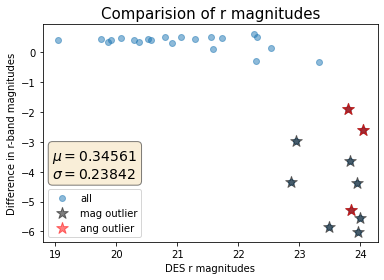

In [32]:
# compare r-band magnitudes from UCS with DES

comparisonmags_r_3sigma_ang = comparisonmags_r.loc[comparisonmags_r['sigma_3ang']==True]

y = comparisonmags_r['r_diff']
x = comparisonmags_r['wavg_mag_psf_r']

textstr = '\n'.join((
    r'$\mu=%.5f$' % (mu_r, ),
    r'$\sigma=%.5f$' % (sigma_r, )))

plt.xlabel('DES r magnitudes')
plt.ylabel('Difference in r-band magnitudes')
plt.title('Comparision of r magnitudes', fontsize = 15)
plt.scatter(x, y, alpha = 0.5, label = 'all')
plt.scatter(comparisonmags_r_3sigma['wavg_mag_psf_r'].values, comparisonmags_r_3sigma['r_diff'].values, 150, \
            alpha = 0.5, color = 'k', marker = '*', label = 'mag outlier')
plt.scatter(comparisonmags_r_3sigma_ang['wavg_mag_psf_r'].values, comparisonmags_r_3sigma_ang['r_diff'].values, 150, \
            alpha = 0.5, color = 'r', marker = '*', label = 'ang outlier')
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(18.95, -3.2, textstr, fontsize=14, verticalalignment='top', bbox=props)
plt.legend()

In [33]:
# comparing DES magnitudes to the original ones in the sheet - y band

comparisonmags_y = des_mags.copy()
comparisonmags_y = comparisonmags_y[comparisonmags_y['y_diff'].notna()]
len(comparisonmags_y)

76

In [34]:
# statistics on mag spread

y_diff_array = comparisonmags_y['y_diff'].to_numpy()

# getting rid of outliers by hand first: +/- 1
y_diff_array = [x for x in y_diff_array if (x <= 1 and x >= -1)]
y_diff_array = np.asarray(y_diff_array)

mu_y = y_diff_array.mean()
sigma_y = y_diff_array.std()

upper_y, lower_y = mu_y + 3*sigma_y, mu_y - 3*sigma_y

In [35]:
# flag 3 sigma

mu_y, sigma_y, sigma_flag = stats_func_1d(comparisonmags_y['y_diff'].to_numpy(), comparisonmags_y, 1, 'y_diff')

comparisonmags_y['sigma_3y'] = np.array(sigma_flag)
comparisonmags_y_3sigma = comparisonmags_y.loc[comparisonmags_y['sigma_3y']==True]
len(comparisonmags_y_3sigma)

5

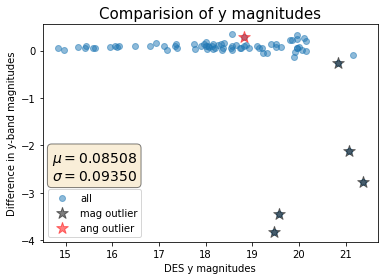

In [36]:
# compare y-band magnitudes from UCS with DES

comparisonmags_y_3sigma_ang = comparisonmags_y.loc[comparisonmags_y['sigma_3ang']==True]

y = comparisonmags_y['y_diff']
x = comparisonmags_y['wavg_mag_psf_y']

textstr = '\n'.join((
    r'$\mu=%.5f$' % (mu_y, ),
    r'$\sigma=%.5f$' % (sigma_y, )))

plt.xlabel('DES y magnitudes')
plt.ylabel('Difference in y-band magnitudes')
plt.title('Comparision of y magnitudes', fontsize = 15)
plt.scatter(x, y, alpha = 0.5, label = 'all')
plt.scatter(comparisonmags_y_3sigma['wavg_mag_psf_y'].values, comparisonmags_y_3sigma['y_diff'].values, 150, \
            alpha = 0.5, color = 'k', marker = '*', label = 'mag outlier')
plt.scatter(comparisonmags_y_3sigma_ang['wavg_mag_psf_y'].values, comparisonmags_y_3sigma_ang['y_diff'].values, 150, \
            alpha = 0.5, color = 'r', marker = '*', label = 'ang outlier')
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(14.7, -2.1, textstr, fontsize=14, verticalalignment='top', bbox=props)
plt.legend()

### Photometric Correction of DES to PS1

We calculate the photometric correction of PS1 to DES by using linear least squares to fit a line between PS1 colors and the difference between magnitudes of PS1 to DES. If multiple PS1 colors can be applied for a photometric fit, such as i-z and z-Y for z magnitudes, the color with the lower spread is used to fit the final line. Outliers are not used for the correction.

In [37]:
# creating a dataframe to perform the correction in the z band
correctionz = comparisonmags_z.loc[comparisonmags_z['sigma_3z'] == False].copy()

# adding the Pan-STARRS colors as columns
correctionz['z-y'] = correctionz['z_P1'] - correctionz['y_P1']
correctionz['i-z'] = correctionz['i_P1'] - correctionz['z_P1']

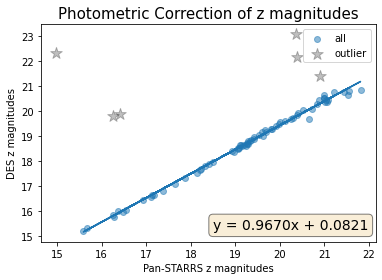

In [38]:
# making the color correction - z band

x = correctionz['z_P1']
y = correctionz['wavg_mag_psf_z']

az, bz = np.polyfit(x, y, 1)

textstr = 'y = {:.4f}x + {:.4f}'.format(az, bz)

plt.ylabel('DES z magnitudes')
plt.xlabel('Pan-STARRS z magnitudes')
plt.title('Photometric Correction of z magnitudes', fontsize = 15)
plt.scatter(x, y, alpha = 0.5, label = 'all')
plt.scatter(comparisonmags_z_3sigmaz['z_P1'].values, comparisonmags_z_3sigmaz['wavg_mag_psf_z'].values, 150, alpha = 0.25, \
            color = 'k', marker= '*', label = 'outlier')
plt.plot(x, az*x + bz) 
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(18.5, 15.7, textstr, fontsize=14, verticalalignment='top', bbox=props)
plt.legend()

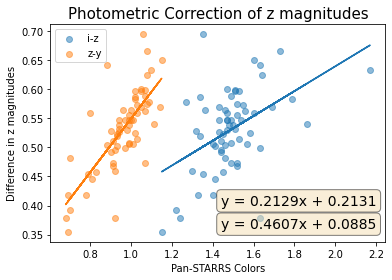

In [39]:
# making the color correction - z band

correctionz = correctionz[correctionz['i-z'].notna()]

x = correctionz['i-z']
x2 = correctionz['z-y']
y = correctionz['z_diff']

azc, bzc = np.polyfit(x, y, 1)
azc2, bzc2 = np.polyfit(x2, y, 1)

textstr = 'y = {:.4f}x + {:.4f}'.format(azc, bzc)
textstr2 = 'y = {:.4f}x + {:.4f}'.format(azc2, bzc2)

plt.ylabel('Difference in z magnitudes')
plt.xlabel('Pan-STARRS Colors')
plt.title('Photometric Correction of z magnitudes', fontsize = 15)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

plt.scatter(x, y, alpha = 0.5, label = 'i-z')
plt.plot(x, azc*x + bzc)
plt.text(1.44, 0.42, textstr, fontsize=14, verticalalignment='top', bbox=props)
plt.legend()
plt.show

plt.scatter(x2, y, alpha = 0.5, label = 'z-y')
plt.plot(x2, azc2*x2 + bzc2) 
plt.text(1.44, 0.38, textstr2, fontsize=14, verticalalignment='top', bbox=props)
plt.legend()
plt.show()

In [40]:
# calculate standard deviations

zy_array = correctionz['z-y'].to_numpy()
zy_array = np.asarray(zy_array)
sigma_zy = zy_array.std()

iz_array = correctionz['i-z'].to_numpy()
iz_array = np.asarray(iz_array)
sigma_iz = iz_array.std()

print(sigma_zy, sigma_iz)

0.11394946124406649 0.15287420168867644


In [41]:
# get a bigger sample

correctionz2 = comparisonmags_z.loc[comparisonmags_z['sigma_3z'] == False].copy()
correctionz2['z-y'] = correctionz2['z_P1'] - correctionz2['y_P1']
correctionz2 = correctionz2[correctionz2['z-y'].notna()]

In [42]:
# standard deviation: 

zy_array2 = correctionz2['z-y'].to_numpy()
zdiff_array = correctionz2['z_diff'].to_numpy()
sigma_zy2 = zy_array2.std()
sigma_zdiff = zdiff_array.std()
sigma_zy2diff = np.sqrt(sigma_zy2 ** 2 + sigma_zdiff ** 2)

[0.17934739] [0.00256211]


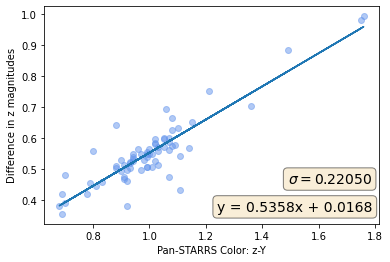

In [43]:
# plot best fit color

y = correctionz2['z_diff']
x = correctionz2['z-y']
x2 = correctionz['z-y']

az_final, bz_final = np.polyfit(x, y, 1)

params, residual, stuff1, stuff2, stuff3 = np.polyfit(x, y, 1, full = True)

zcorr_mse = 1/(len(y)) * residual
print(residual, zcorr_mse)

textstr = 'y = {:.4f}x + {:.4f}'.format(az_final, bz_final)
textstr2 = r'$\sigma=%.5f$' % (sigma_zy2diff, )

plt.ylabel('Difference in z magnitudes')
plt.xlabel('Pan-STARRS Color: z-Y')
#plt.title('Photometric Correction of z magnitudes', fontsize = 15)
plt.scatter(x, y, alpha = 0.5, color = 'cornflowerblue', label = 'z-y')
plt.plot(x, az_final*x + bz_final) 
#plt.plot(x2, azc2*x2 + bzc2, label = 'previous fit') 
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(1.24, 0.4, textstr, fontsize=14, verticalalignment='top', bbox=props)
plt.text(1.49, 0.49, textstr2, fontsize=14, verticalalignment='top', bbox=props)
#plt.legend()
plt.savefig('zmagcorrdes.png')

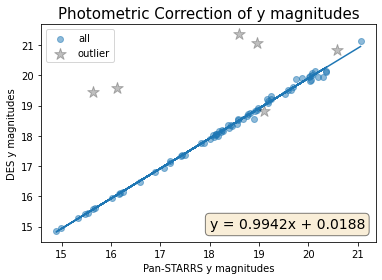

In [44]:
# making the color correction - y band

correctiony = comparisonmags_y.loc[comparisonmags_y['sigma_3y'] == False]
correctiony = correctiony.loc[correctiony['sigma_3ang'] == False]

x = correctiony['y_P1']
y = correctiony['wavg_mag_psf_y']

ay, by = np.polyfit(x, y, 1)

textstr = 'y = {:.4f}x + {:.4f}'.format(ay, by)

plt.ylabel('DES y magnitudes')
plt.xlabel('Pan-STARRS y magnitudes')
plt.title('Photometric Correction of y magnitudes', fontsize = 15)
plt.scatter(x, y, alpha = 0.5, label = 'all')
plt.scatter(comparisonmags_y_3sigma['y_P1'].values, comparisonmags_y_3sigma['wavg_mag_psf_y'].values, 150, alpha = 0.25, \
            color = 'k', marker= '*', label = 'outlier')
plt.scatter(comparisonmags_y_3sigma_ang['y_P1'].values, comparisonmags_y_3sigma_ang['wavg_mag_psf_y'].values, 150, alpha = 0.25, \
            color = 'k', marker= '*')
plt.plot(x, ay*x + by) 
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(18, 15.3, textstr, fontsize=14, verticalalignment='top', bbox=props)
plt.legend()


In [45]:
# making the color columns

correctiony['z-y'] = correctiony['z_P1'] - correctiony['y_P1']
correctiony['i-z'] = correctiony['i_P1'] - correctiony['z_P1']
correctiony = correctiony[correctiony['i-z'].notna()]

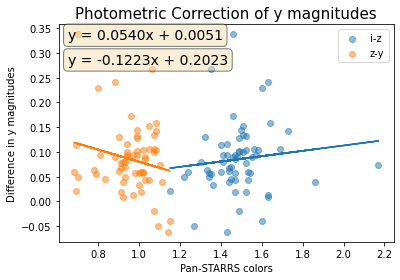

In [46]:
# correction in y

x = correctiony['i-z']
x2 = correctiony['z-y']
y = correctiony['y_diff']

ayc, byc = np.polyfit(x, y, 1)
ayc2, byc2 = np.polyfit(x2, y, 1)

textstr = 'y = {:.4f}x + {:.4f}'.format(ayc, byc)
textstr2 = 'y = {:.4f}x + {:.4f}'.format(ayc2, byc2)

plt.ylabel('Difference in y magnitudes')
plt.xlabel('Pan-STARRS colors')
plt.title('Photometric Correction of y magnitudes', fontsize = 15)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

plt.scatter(x, y, alpha = 0.5, label = 'i-z')
plt.plot(x, ayc*x + byc) 
plt.text(0.65, 0.35, textstr, fontsize=14, verticalalignment='top', bbox=props)

plt.scatter(x2, y, alpha = 0.5, label = 'z-y')
plt.plot(x2, ayc2*x2 + byc2) 
plt.text(0.65, 0.3, textstr2, fontsize=14, verticalalignment='top', bbox=props)
plt.legend()

In [47]:
# standard deviations

zyy_array = correctiony['z-y'].to_numpy()
zyy_array = np.asarray(zyy_array)
sigma_zyy = zyy_array.std()

izy_array = correctiony['i-z'].to_numpy()
izy_array = np.asarray(izy_array)
sigma_izy = izy_array.std()

print(sigma_zyy, sigma_izy)

0.1145979943636658 0.14920810739773968


In [48]:
# bigger sample

correctiony2 = comparisonmags_y.loc[comparisonmags_y['sigma_3y'] == False].copy()
correctiony2['z-y'] = correctiony2['z_P1'] - correctiony2['y_P1']
correctiony2 = correctiony2[correctiony2['z-y'].notna()]

In [49]:
# standard deviation

zyy_array2 = correctiony2['z-y'].to_numpy()
ydiff_array = correctiony2['y_diff'].to_numpy()
sigma_zyy2 = zyy_array2.std()
sigma_ydiff = ydiff_array.std()
sigma_zyy2diff = np.sqrt(sigma_zyy2 ** 2 + sigma_ydiff ** 2)

[0.42345205] [0.00613699]


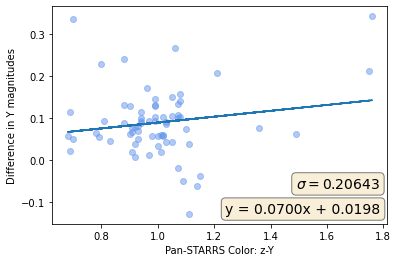

In [50]:
# improved color correction in y band

y = correctiony2['y_diff']
x = correctiony2['z-y']
x2 = correctiony['z-y']

ay_final, by_final = np.polyfit(x, y, 1)

params, residual, stuff1, stuff2, stuff3 = np.polyfit(x, y, 1, full = True)

zcorr_mse = 1/(len(y)) * residual
print(residual, zcorr_mse)

textstr = 'y = {:.4f}x + {:.4f}'.format(ay_final, by_final)
textstr2 = r'$\sigma=%.5f$' % (sigma_zyy2diff, )

plt.ylabel('Difference in Y magnitudes')
plt.xlabel('Pan-STARRS Color: z-Y')
#plt.title('Photometric Correction of y magnitudes', fontsize = 15)
plt.scatter(x, y, alpha = 0.5, color = 'cornflowerblue', label = 'z-y')
plt.plot(x, ay_final*x + by_final) 
#plt.plot(x2, ayc2*x2 + byc2, label = 'previous fit') 
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(1.24, -0.1, textstr, fontsize=14, verticalalignment='top', bbox=props)
plt.text(1.49, -0.04, textstr2, fontsize=14, verticalalignment='top', bbox=props)
#plt.legend()
plt.savefig('ymagcorrdes.png')

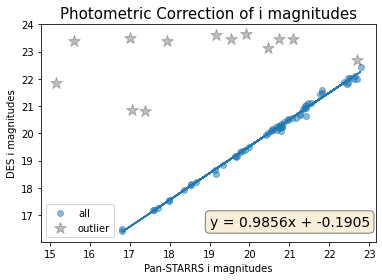

In [51]:
# making the color correction - i band

correctioni = comparisonmags_i.loc[comparisonmags_i['sigma_3i'] == False].copy()

x = correctioni['i_P1']
y = correctioni['wavg_mag_psf_i']

ai, bi = np.polyfit(x, y, 1)

textstr = 'y = {:.4f}x + {:.4f}'.format(ai, bi)

plt.ylabel('DES i magnitudes')
plt.xlabel('Pan-STARRS i magnitudes')
plt.title('Photometric Correction of i magnitudes', fontsize = 15)
plt.scatter(x, y, alpha = 0.5, label = 'all')
plt.scatter(comparisonmags_i_3sigma['i_P1'].values, comparisonmags_i_3sigma['wavg_mag_psf_i'].values, 150, alpha = 0.25, \
            color = 'k', marker= '*', label = 'outlier')
plt.plot(x, ai*x + bi) 
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(19, 17, textstr, fontsize=14, verticalalignment='top', bbox=props)
plt.legend()


In [52]:
# creating color columns

correctioni['i-z'] = correctiony['i_P1'] - correctiony['z_P1']
correctioni['r-i'] = correctiony['r_P1'] - correctiony['i_P1']
correctioni = correctioni[correctioni['i-z'].notna()]

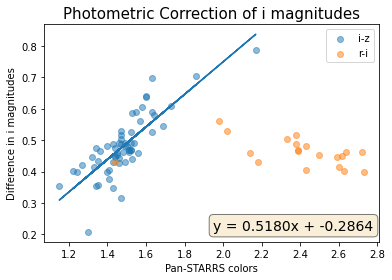

In [53]:
# making the color correction - i band

x = correctioni['i-z']
x2 = correctioni['r-i']
y = correctioni['i_diff']

aic, bic = np.polyfit(x, y, 1)

textstr = 'y = {:.4f}x + {:.4f}'.format(aic, bic)

plt.ylabel('Difference in i magnitudes')
plt.xlabel('Pan-STARRS colors')
plt.title('Photometric Correction of i magnitudes', fontsize = 15)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

plt.scatter(x, y, alpha = 0.5, label = 'i-z')
plt.plot(x, aic*x + bic) 
plt.text(1.95, 0.25, textstr, fontsize=14, verticalalignment='top', bbox=props)

plt.scatter(x2, y, alpha = 0.5, label = 'r-i')
plt.legend()


In [54]:
# standard deviation

izi_array = correctioni['i-z'].to_numpy()
idiff_array = correctioni['i_diff'].to_numpy()
sigma_izi = izi_array.std()
sigma_idiff = idiff_array.std()
sigma_izidiff = np.sqrt(sigma_izi ** 2 + sigma_idiff ** 2)

[0.19698909] [0.00322933]


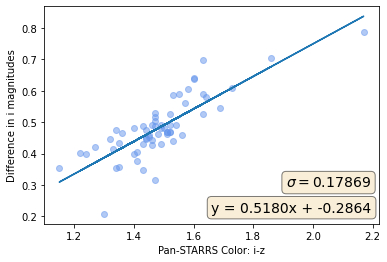

In [55]:
# final i color correction

x = correctioni['i-z']
y = correctioni['i_diff']

ai_final, bi_final = np.polyfit(x, y, 1)

params, residual, stuff1, stuff2, stuff3 = np.polyfit(x, y, 1, full = True)

icorr_mse = 1/(len(y)) * residual
print(residual, icorr_mse)

textstr = 'y = {:.4f}x + {:.4f}'.format(ai_final, bi_final)
textstr2 = r'$\sigma=%.5f$' % (sigma_izidiff, )

plt.ylabel('Difference in i magnitudes')
plt.xlabel('Pan-STARRS Color: i-z')
#plt.title('Photometric Correction of i magnitudes', fontsize = 15)
plt.scatter(x, y, alpha = 0.5, color = 'cornflowerblue', label = 'i-z')
plt.plot(x, ai_final*x + bi_final) 
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(1.66, 0.25, textstr, fontsize=14, verticalalignment='top', bbox=props)
plt.text(1.91, 0.33, textstr2, fontsize=14, verticalalignment='top', bbox=props)
#plt.legend()
plt.savefig('imagcorrdes.png')

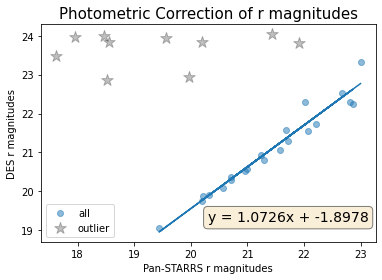

In [56]:
# making the color correction - r band

correctionr = comparisonmags_r.loc[comparisonmags_r['sigma_3r'] == False].copy()

x = correctionr['r_P1']
y = correctionr['wavg_mag_psf_r']

ar, br = np.polyfit(x, y, 1)

textstr = 'y = {:.4f}x + {:.4f}'.format(ar, br)

plt.ylabel('DES r magnitudes')
plt.xlabel('Pan-STARRS r magnitudes')
plt.title('Photometric Correction of r magnitudes', fontsize = 15)
plt.scatter(x, y, alpha = 0.5, label = 'all')
plt.scatter(comparisonmags_r_3sigma['r_P1'].values, comparisonmags_r_3sigma['wavg_mag_psf_r'].values, 150, alpha = 0.25, \
            color = 'k', marker= '*', label = 'outlier')
plt.plot(x, ar*x + br) 
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(20.3, 19.5, textstr, fontsize=14, verticalalignment='top', bbox=props)
plt.legend()


In [57]:
# standard deviation

correctionr['r-i'] = correctionr['r_P1'] - correctionr['i_P1']
ri_array = correctionr['r-i'].to_numpy()
rdiff_array = correctionr['r_diff'].to_numpy()
sigma_ri = ri_array.std()
sigma_rdiff = rdiff_array.std()
sigma_ridiff = np.sqrt(sigma_ri ** 2 + sigma_rdiff ** 2)

[0.54794679] [0.0260927]


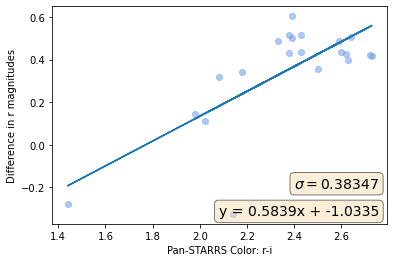

In [58]:
# making the color correction - r band

y = correctionr['r_diff']
x = correctionr['r-i']

ar_final, br_final = np.polyfit(x, y, 1)

params, residual, stuff1, stuff2, stuff3 = np.polyfit(x, y, 1, full = True)

rcorr_mse = 1/(len(y)) * residual
print(residual, rcorr_mse)

textstr = 'y = {:.4f}x + {:.4f}'.format(ar_final, br_final)
textstr2 = r'$\sigma=%.5f$' % (sigma_ridiff, )

plt.ylabel('Difference in r magnitudes')
plt.xlabel('Pan-STARRS Color: r-i')
#plt.title('Photometric Correction of r magnitudes', fontsize = 15)
plt.scatter(x, y, alpha = 0.5, color = 'cornflowerblue', label = 'r-i')
plt.plot(x, ar_final*x + br_final) 
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(2.4, -0.15, textstr2, fontsize=14, verticalalignment='top', bbox=props)
plt.text(2.08, -0.28, textstr, fontsize=14, verticalalignment='top', bbox=props)
#plt.plot(x, 0.142*x + 0.01, label = 'PS1 correction')
#plt.legend()
plt.savefig('rmagcorrdes.png')

In [59]:
# apply the photometric correction to the DES data

correctDES = des_mags.copy()

# get the sigma flags for magnitude on the larger sample
# z: 
mu_zcorr, sigma_zcorr, sigma_flag_z = stats_func_1d(correctDES['z_diff'].to_numpy(), correctDES, 1, 'z_diff')
correctDES['sigma_3z'] = np.array(sigma_flag_z)

# y: 
mu_ycorr, sigma_ycorr, sigma_flag_y = stats_func_1d(correctDES['y_diff'].to_numpy(), correctDES, 1, 'y_diff')
correctDES['sigma_3y'] = np.array(sigma_flag_y)

# i:
mu_icorr, sigma_icorr, sigma_flag_i = stats_func_1d(correctDES['i_diff'].to_numpy(), correctDES, 1, 'i_diff')
correctDES['sigma_3i'] = np.array(sigma_flag_i)

# r: 
mu_rcorr, sigma_rcorr, sigma_flag_r = stats_func_1d(correctDES['r_diff'].to_numpy(), correctDES, 1, 'r_diff')
correctDES['sigma_3r'] = np.array(sigma_flag_r)

# remove the photometric band outliers
correctDES = correctDES.loc[correctDES['sigma_3z'] == False]
correctDES = correctDES.loc[correctDES['sigma_3y'] == False]
correctDES = correctDES.loc[correctDES['sigma_3i'] == False]
correctDES = correctDES.loc[correctDES['sigma_3r'] == False]

# take out angular separation outliers
correctDES = correctDES.loc[correctDES['sigma_3ang'] == False]

# remove stars with no photometric data from DES 
correctDES = correctDES.dropna(subset=['wavg_mag_psf_r', 'wavg_mag_psf_i', 'wavg_mag_psf_z', 'wavg_mag_psf_y'], thresh=1)

# remove stars with no photometric data from Pan-STARRS
correctDES = correctDES.dropna(subset = ['r_P1', 'i_P1', 'z_P1', 'y_P1'], thresh = 1)

correctDES

,ra,dec,wavg_mag_psf_r,wavg_mag_psf_i,wavg_mag_psf_z,wavg_mag_psf_y,wavg_magerr_psf_r,wavg_magerr_psf_i,wavg_magerr_psf_z,wavg_magerr_psf_y,...,i_diff,z_diff,y_diff,sigma_3,angular_sep,sigma_3ang,sigma_3z,sigma_3y,sigma_3i,sigma_3r
3,2.666957,1.005466,24.037722,23.675348,NaN,NaN,0.251121,0.285420,NaN,NaN,...,NaN,NaN,NaN,False,8.705721,False,False,False,False,False
10,4.798389,0.504706,21.287258,18.852976,17.322695,16.807170,0.008878,0.001935,0.000912,0.002228,...,0.487024,0.547305,0.092830,False,0.804628,False,False,False,False,False
16,5.539349,-1.177579,21.936010,19.327848,17.805836,17.341230,0.012653,0.002216,0.001219,0.002712,...,0.442152,0.504164,0.088770,False,2.130136,False,False,False,False,False
20,6.924922,5.061581,22.288687,20.139389,18.532766,17.961601,0.034705,0.009296,0.004204,0.008451,...,0.430611,0.547234,0.128399,False,0.104457,False,False,False,False,False
25,8.180081,-22.624253,21.578238,19.141325,17.652975,17.170086,0.014811,0.003452,0.002137,0.004460,...,0.528675,0.547025,0.019914,False,1.609696,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,354.066735,0.714808,23.137613,20.478704,18.882511,18.371986,0.047207,0.006513,0.003090,0.006026,...,0.491296,0.547489,0.058014,False,0.354370,False,False,False,False,False
293,356.029159,1.254371,22.711845,20.271175,18.783188,18.274845,0.026288,0.004554,0.002776,0.005966,...,0.488825,0.546812,0.115155,False,2.028089,False,False,False,False,False
294,356.413036,0.920224,20.288544,17.526035,15.948458,15.440567,0.003564,0.000711,0.000370,0.000908,...,0.463965,0.531542,0.099433,False,1.857486,False,False,False,False,False
295,356.999173,-0.263156,23.324759,20.400578,18.951616,18.533712,0.051839,0.005045,0.002780,0.006658,...,0.459422,0.458384,0.046288,False,0.838610,False,False,False,False,False


In [60]:
# add pan-starrs color columns

correctDES['r_i_ps'] = correctDES['r_P1'] - correctDES['i_P1']
correctDES['i_z_ps'] = correctDES['i_P1'] - correctDES['z_P1']
correctDES['z_y_ps'] = correctDES['z_P1'] - correctDES['y_P1']

# create DES color columns

correctDES['r_i_des'] = correctDES['wavg_mag_psf_r'] - correctDES['wavg_mag_psf_i']
correctDES['i_z_des'] = correctDES['wavg_mag_psf_i'] - correctDES['wavg_mag_psf_z']
correctDES['z_y_des'] = correctDES['wavg_mag_psf_z'] - correctDES['wavg_mag_psf_y']

In [61]:
# do photometric correction for four bands (skipping g, as there are not enough values in that band for any star)

# r:
correctDES['r_P1_new'] = correctDES['r_P1'] - (ar_final * correctDES['r_i_ps']) - br_final

# i: 
correctDES['i_P1_new'] = correctDES['i_P1'] - (ai_final * correctDES['i_z_ps']) - bi_final

# z:
correctDES['z_P1_new'] = correctDES['z_P1'] - (az_final * correctDES['z_y_ps']) - bz_final

# y:
correctDES['y_P1_new'] = correctDES['y_P1'] - (ay_final * correctDES['z_y_ps']) - by_final

In [62]:
# re-calculate the new differences

correctDES['r_diff_new'] = correctDES['r_P1_new'] - correctDES['wavg_mag_psf_r']
correctDES['i_diff_new'] = correctDES['i_P1_new'] - correctDES['wavg_mag_psf_i']
correctDES['z_diff_new'] = correctDES['z_P1_new'] - correctDES['wavg_mag_psf_z']
correctDES['y_diff_new'] = correctDES['y_P1_new'] - correctDES['wavg_mag_psf_y']

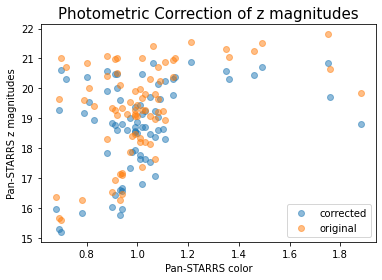

In [63]:
# check the photometric correction

x = correctDES['z_y_ps']
y = correctDES['z_P1_new']
z = correctDES['z_P1']

plt.xlabel('Pan-STARRS color')
plt.ylabel('Pan-STARRS z magnitudes')
plt.title('Photometric Correction of z magnitudes', fontsize = 15)
plt.scatter(x, y, alpha = 0.5, label = 'corrected')
plt.scatter(x, z, alpha = 0.5, label = 'original')

plt.legend()

Text(0, 0.5, 'DES z-y color')

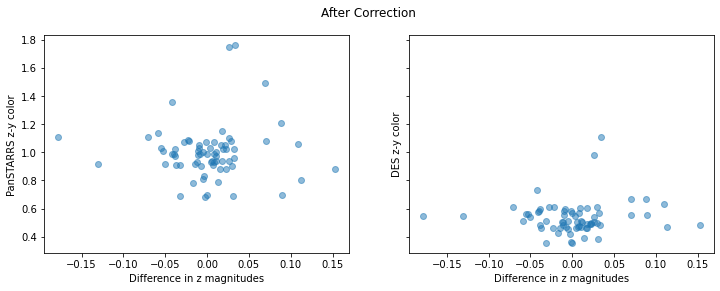

In [64]:
# check the photometric correction

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(12, 4))

x = correctDES['z_diff_new']
y1 = correctDES['z_y_ps']
y2 = correctDES['z_y_des']

fig.suptitle('After Correction')

ax1.scatter(x, y1, alpha = 0.5)
ax1.set_xlabel('Difference in z magnitudes')

ax2.scatter(x, y2, alpha = 0.5)
ax2.set_xlabel('Difference in z magnitudes')

ax1.set_ylabel('PanSTARRS z-y color')
ax2.set_ylabel('DES z-y color')

Text(0, 0.5, 'DES color')

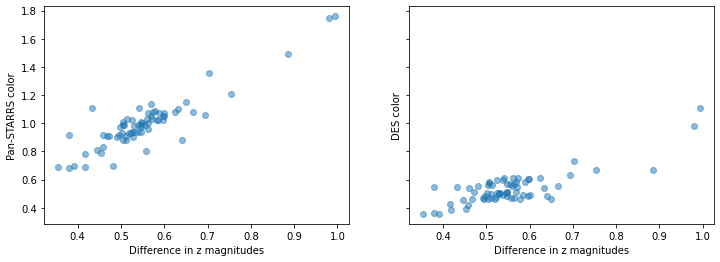

In [65]:
# check the photometric correction

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(12, 4))

x1 = correctDES['z_diff']
y1 = correctDES['z_y_ps']
y2 = correctDES['z_y_des']

ax1.scatter(x1, y1, alpha = 0.5)
ax1.set_xlabel('Difference in z magnitudes')
ax1.set_ylabel('Pan-STARRS color')

ax2.scatter(x1, y2, alpha = 0.5)
ax2.set_xlabel('Difference in z magnitudes')
ax2.set_ylabel('DES color')

Text(0.5, 1.0, 'Comparision of Survey Colors')

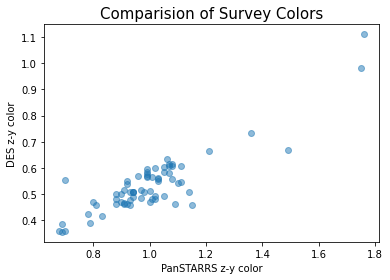

In [66]:
# plotting the colors

x = correctDES['z_y_ps']
y = correctDES['z_y_des']

plt.scatter(x, y, alpha = 0.5)
plt.xlabel('PanSTARRS z-y color')
plt.ylabel('DES z-y color')
plt.title('Comparision of Survey Colors', fontsize = 15)

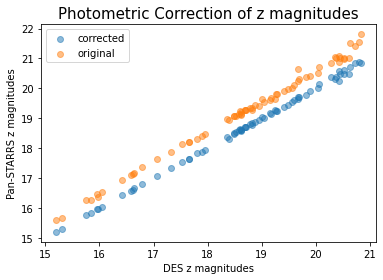

In [67]:
# check the photometric correction

x = correctDES['wavg_mag_psf_z']
y = correctDES['z_P1_new']
z = correctDES['z_P1']

plt.xlabel('DES z magnitudes')
plt.ylabel('Pan-STARRS z magnitudes')
plt.title('Photometric Correction of z magnitudes', fontsize = 15)
plt.scatter(x, y, alpha = 0.5, label = 'corrected')
plt.scatter(x, z, alpha = 0.5, label = 'original')
plt.legend()

## CatWISE2020 Query

The CatWISE2020 query is a catalogue of almost 1.9 billion sources taken with the Wide-Field Infrared Survey Explorer (WISE, Marocco et al. 2021). The catalogue includes magnitudes from two infrared photometric bands: W1 at 3.6 microns, and W2 at 4.2 microns, and proper motions in right ascension and declination. The following two quality flags are used:

CC_FLAGS - four-char flag that indicates if a pixel is contaminated by an artifact in the four allwise bands \
AB_FLAGS - two-char flag that indicates contaminated sources 

to locate the UltracoolSheet UCDs in the CatWISE2020 catalogue. 

In [68]:
# finds all UC Stars with an ra/dec that returns a catwise2020 query result

insearch_cat = []
ra_list = []
dec_list = []
radius = 0.007

for i in range(len(ucs)):
    ra0 = ucs.iloc[i, 1] # in degrees, right ascension
    ra_list.append(ra0)
    dec0 = ucs.iloc[i, 2] # in degrees, declinarion
    dec_list.append(dec0)
    query = """
    SELECT ra, dec, w1mpro, w2mpro
    FROM catwise2020.main,
    q3c_dist(ra, dec, {:f}, {:f}) as rdist
    WHERE cc_flags = '0000'
    AND ab_flags = '00'
    AND q3c_radial_query(ra,dec,{:f},{:f},{:f})
    order by rdist
    """.format(ra0, dec0, ra0, dec0, radius)
    response = qc.query(sql=query,format='csv')
    sources = convert(response,'pandas')
    if len(sources) >= 1:   # need at least one result 
        insearch_cat.append(True)
    else:
        insearch_cat.append(False)


In [69]:
# create a true/false column with the search results

ucs['Cat_Search'] = np.array(insearch_cat)

In [70]:
# take only the columns labelled with 'true' to get all potential matches

cat_search = ucs.loc[ucs['Cat_Search']==True].copy()
cat_search = cat_search.reset_index(drop=True)
cat_search

,name,ucs_ra,ucs_dec,ucs_pmra,ucs_pmdec,r_P1,i_P1,z_P1,y_P1,rerr_P1,...,Herr_2MASS,Kserr_2MASS,W1,W2,W1err,W2err,binary,spectral_type,DES_Search,Cat_Search
0,ULAS J000010.43+113602.2,0.0434,11.6020,-0.09000,-0.00800,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,16.868,16.613,0.116,NaN,N,21.5,False,True
1,SDSS J000112.18+153535.5,0.3007,15.5932,0.14300,-0.17470,NaN,20.37,18.85,17.81,NaN,...,0.044,0.044,12.965,12.539,0.024,0.024,N,13.7,False,True
2,WISEA J000131.93-084126.9,0.3821,-8.6900,0.33990,-0.30500,NaN,20.21,18.57,17.57,NaN,...,0.090,0.090,14.344,13.993,0.031,0.047,N,11.0,False,True
3,SDSS J000250.98+245413.8,0.7124,24.9039,0.02200,-0.04600,NaN,22.30,20.30,19.31,NaN,...,0.217,0.217,14.819,14.574,0.032,0.058,N,15.5,False,True
4,2MASS J00040288-6410358,1.0127,-64.1768,0.06400,-0.04700,NaN,NaN,NaN,NaN,NaN,...,0.046,0.046,13.409,12.959,0.024,0.026,N,11.0,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2685,SDSS J235835.45-000909.5,359.6478,-0.1526,-0.09700,-0.22900,NaN,21.09,19.55,18.73,NaN,...,0.245,NaN,NaN,NaN,NaN,NaN,N,10.0,True,True
2686,SDSS J235841.98+000622.0,359.6749,0.1060,0.12800,-0.03200,NaN,21.82,20.41,19.54,NaN,...,0.194,0.194,15.439,15.177,0.044,0.094,N,11.5,False,True
2687,APMPM J2359-6246,359.6787,-62.7618,0.59065,0.08356,NaN,NaN,NaN,NaN,NaN,...,0.023,0.023,10.305,10.088,0.023,0.020,N,6.0,True,True
2688,WISEP J235941.07-733504.8,359.9213,-73.5847,0.28100,0.03900,NaN,NaN,NaN,NaN,NaN,...,0.071,0.129,15.263,13.338,0.034,0.028,N,26.5,False,True


In [71]:
# takes the 2690 stars in catwise field and matches them to catwise query

cat_query = pd.DataFrame()
no_of_matches = []

for i in range(len(cat_search)):
    ra0 = cat_search.iloc[i, 1]  # in degrees, right ascension
    dec0 = cat_search.iloc[i, 2] # in degrees, declinarion
    w1s = cat_search.iloc[i, cat_search.columns.get_loc('W1')] # w1 allwise photometry
    w2s = cat_search.iloc[i, cat_search.columns.get_loc('W2')] # w2 allwise photometry
    names = cat_search.iloc[i, 0] # unique name identifier
    query = """
    SELECT ra, dec, w1mpro, w2mpro, w1sigmpro, w2sigmpro, pmra, pmdec
    FROM catwise2020.main,
    q3c_dist(ra, dec, {:f}, {:f}) as rdist
    WHERE cc_flags = '0000'
    AND ab_flags = '00'
    AND q3c_radial_query(ra,dec,{:f},{:f},{:f})
    order by rdist
    """.format(ra0, dec0, ra0, dec0, radius)
    response = qc.query(sql=query,format='csv')
    sources = convert(response,'pandas')
    sources['ra_comp'] = (sources['ra'] - ra0) * np.cos(dec0 * (np.pi / 180))       # difference in right ascension
    sources['dec_comp'] = sources['dec'] - dec0                                     # difference in declination
    sources['w1_comp'] = w1s - sources['w1mpro']
    sources['w2_comp'] = w2s - sources['w2mpro']
    sources = sources[sources.w1_comp.abs() <= 0.5]
    sources = sources[sources.w2_comp.abs() <= 0.5]
    closestmatch = sources.copy()
    closestmatch = closestmatch.head(1)
    closestmatch['name'] = names
    no_of_matches.append(len(sources))
    cat_query = pd.concat([cat_query, closestmatch], ignore_index = True)


In [72]:
cat_query

,ra,dec,w1mpro,w2mpro,w1sigmpro,w2sigmpro,pmra,pmdec,ra_comp,dec_comp,w1_comp,w2_comp,name
0,0.043334,11.601974,16.877,16.869,0.044,0.148,0.03135,-0.01090,-0.000065,-0.000026,-0.009,-0.256,ULAS J000010.43+113602.2
1,0.301335,15.592465,12.967,12.557,0.012,0.009,0.14627,-0.17977,0.000612,-0.000735,-0.002,-0.018,SDSS J000112.18+153535.5
2,0.383510,-8.691290,14.354,14.067,0.016,0.016,0.34928,-0.33492,0.001394,-0.001290,-0.010,-0.074,WISEA J000131.93-084126.9
3,0.712486,24.903770,14.833,14.576,0.016,0.021,0.07238,-0.02756,0.000078,-0.000130,-0.014,-0.002,SDSS J000250.98+245413.8
4,1.012763,-64.176842,13.405,12.974,0.014,0.010,0.10060,-0.06658,0.000027,-0.000042,0.004,-0.015,2MASS J00040288-6410358
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002,359.045483,-34.435950,11.659,11.340,0.012,0.008,0.09938,-0.33788,0.000316,-0.001350,-0.030,-0.027,SSSPM J2356-3426
2003,359.075358,7.905365,15.650,15.311,0.022,0.039,0.17212,-0.19156,0.000255,-0.000235,-0.033,0.039,ULAS J235618.01+075420.4
2004,359.318792,12.460781,15.969,14.153,0.029,0.019,0.03453,-0.48802,0.000090,-0.000719,-0.227,-0.135,WISE J235716.49+122741.8
2005,359.675408,0.105863,15.413,15.143,0.021,0.036,0.11342,-0.07621,0.000508,-0.000137,0.026,0.034,SDSS J235841.98+000622.0


In [73]:
cat_query['name'].nunique()

2007

In [74]:
# combine the query with the information from the ultracool sheet

cat_mags = pd.merge(cat_query, cat_search, how = 'inner', on = 'name')
cat_mags = cat_mags.dropna(subset = ['ra', 'dec'])

# magnitude difference between allwise and catwise
cat_mags['w1_diff'] = cat_mags['W1'] - cat_mags['w1mpro']
cat_mags['w2_diff'] = cat_mags['W2'] - cat_mags['w2mpro']
cat_mags

,ra,dec,w1mpro,w2mpro,w1sigmpro,w2sigmpro,pmra,pmdec,ra_comp,dec_comp,...,W1,W2,W1err,W2err,binary,spectral_type,DES_Search,Cat_Search,w1_diff,w2_diff
0,0.043334,11.601974,16.877,16.869,0.044,0.148,0.03135,-0.01090,-0.000065,-0.000026,...,16.868,16.613,0.116,NaN,N,21.5,False,True,-0.009,-0.256
1,0.301335,15.592465,12.967,12.557,0.012,0.009,0.14627,-0.17977,0.000612,-0.000735,...,12.965,12.539,0.024,0.024,N,13.7,False,True,-0.002,-0.018
2,0.383510,-8.691290,14.354,14.067,0.016,0.016,0.34928,-0.33492,0.001394,-0.001290,...,14.344,13.993,0.031,0.047,N,11.0,False,True,-0.010,-0.074
3,0.712486,24.903770,14.833,14.576,0.016,0.021,0.07238,-0.02756,0.000078,-0.000130,...,14.819,14.574,0.032,0.058,N,15.5,False,True,-0.014,-0.002
4,1.012763,-64.176842,13.405,12.974,0.014,0.010,0.10060,-0.06658,0.000027,-0.000042,...,13.409,12.959,0.024,0.026,N,11.0,True,True,0.004,-0.015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002,359.045483,-34.435950,11.659,11.340,0.012,0.008,0.09938,-0.33788,0.000316,-0.001350,...,11.629,11.313,0.023,0.020,N,9.0,False,True,-0.030,-0.027
2003,359.075358,7.905365,15.650,15.311,0.022,0.039,0.17212,-0.19156,0.000255,-0.000235,...,15.617,15.350,0.047,0.099,N,20.0,False,True,-0.033,0.039
2004,359.318792,12.460781,15.969,14.153,0.029,0.019,0.03453,-0.48802,0.000090,-0.000719,...,15.742,14.018,0.048,0.040,N,26.0,False,True,-0.227,-0.135
2005,359.675408,0.105863,15.413,15.143,0.021,0.036,0.11342,-0.07621,0.000508,-0.000137,...,15.439,15.177,0.044,0.094,N,11.5,False,True,0.026,0.034


In [75]:
cat_mags.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2007 entries, 0 to 2006
Data columns (total 41 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ra             2007 non-null   float64
 1   dec            2007 non-null   float64
 2   w1mpro         2007 non-null   float64
 3   w2mpro         2007 non-null   float64
 4   w1sigmpro      2006 non-null   float64
 5   w2sigmpro      2007 non-null   float64
 6   pmra           2007 non-null   float64
 7   pmdec          2007 non-null   float64
 8   ra_comp        2007 non-null   float64
 9   dec_comp       2007 non-null   float64
 10  w1_comp        2007 non-null   float64
 11  w2_comp        2007 non-null   float64
 12  name           2007 non-null   object 
 13  ucs_ra         2007 non-null   float64
 14  ucs_dec        2007 non-null   float64
 15  ucs_pmra       1946 non-null   float64
 16  ucs_pmdec      1946 non-null   float64
 17  r_P1           707 non-null    float64
 18  i_P1    

### Positional and Photometric Outliers

Positional outliers are visually selected. An additional mathematical calculation confirms these outliers: First, a subset of sources with a difference of less than 12 arcseconds in right ascension and declination are selected. The 2-dimensional standard deviation is calculated. We retain 3 sigma of the sample using this standard deviation. Angular separation outliers are also identified using the same technique, but a separation of 15 arcseconds is used as the cutoff.

Photometric outliers are found following the same process as the DES outliers, with a difference of 1 magnitude used as the cutoff. 

In [76]:
# converting to arc seconds

cat_mags['dec_comp'] = cat_mags['dec_comp'].apply(lambda x: x*3600)
cat_mags['ra_comp'] = cat_mags['ra_comp'].apply(lambda x: x*3600)

In [77]:
# high proper motion objects - top 20
highpmra_cat = cat_mags.reindex(cat_mags.ucs_pmra.abs().sort_values(ascending = False).index).head(20)
highpmdec_cat = cat_mags.reindex(cat_mags.ucs_pmdec.abs().sort_values(ascending = False).index).head(20)
binary_cat = cat_mags[cat_mags.binary != 'N']

In [78]:
# flag 3 sigma outliers

sigma_pos_c, sigma_flag = stats_func_2d(cat_mags['ra_comp'].to_numpy(), cat_mags['dec_comp'].to_numpy(), cat_mags, \
                                        12, 'ra_comp', 'dec_comp')
cat_mags['sigma_3'] = np.array(sigma_flag)
cat_mags_3sigma = cat_mags.loc[cat_mags['sigma_3']==True]
len(cat_mags_3sigma)

8

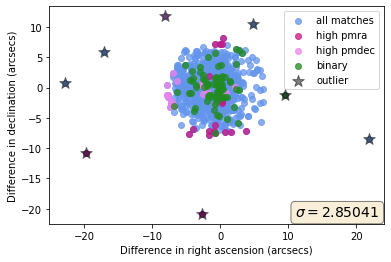

In [79]:
# plot the separation

textstr = ''r'$\sigma=%.5f$' % (sigma_pos_c, )

plt.scatter(cat_mags['dec_comp'].values, cat_mags['ra_comp'].values, alpha = 0.75, color = 'cornflowerblue', label = 'all matches')
plt.scatter(highpmra_cat['dec_comp'].values, highpmra_cat['ra_comp'].values, alpha = 0.75, color = 'mediumvioletred', label = 'high pmra')
plt.scatter(highpmdec_cat['dec_comp'].values, highpmdec_cat['ra_comp'].values, alpha = 0.75, color = 'violet', label = 'high pmdec')
plt.scatter(binary_cat['dec_comp'].values, binary_cat['ra_comp'].values, alpha = 0.75, color = 'forestgreen', label = 'binary')
plt.scatter(cat_mags_3sigma['dec_comp'].values, cat_mags_3sigma['ra_comp'].values, 150, alpha = 0.5, \
           color = 'k', marker= '*', label = 'outlier')
plt.ylabel('Difference in declination (arcsecs)')
plt.xlabel('Difference in right ascension (arcsecs)')
#plt.title('Accuracy according to Coordinates (CatWISE)', fontsize = 15)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(11, -19.5, textstr, fontsize=14, verticalalignment='top', bbox=props)
plt.legend()
plt.savefig('coordaccuracycatucs.png')

In [80]:
# need to convert to radians from degrees (1" × π/(180))

cat_mags['ra'] = cat_mags['ra'].apply(lambda x: x * (np.pi/180))
cat_mags['dec'] = cat_mags['dec'].apply(lambda x: x * (np.pi/180))
cat_mags['ucs_ra'] = cat_mags['ucs_ra'].apply(lambda x: x * (np.pi/180))
cat_mags['ucs_dec'] = cat_mags['ucs_dec'].apply(lambda x: x * (np.pi/180))

In [81]:
# calculate radial and angular separation

ang_dis_list = []

for i in range(len(cat_mags)):
    ra_cat = cat_mags.iloc[i, cat_mags.columns.get_loc('ra')]        # in radians, right ascension of CatWISE
    dec_cat = cat_mags.iloc[i, cat_mags.columns.get_loc('dec')]      # in radians, declinarion of CatWISE
    ra_ucs = cat_mags.iloc[i, cat_mags.columns.get_loc('ucs_ra')]    # in radians, right ascension of UCS
    dec_ucs = cat_mags.iloc[i, cat_mags.columns.get_loc('ucs_dec')]  # in radians, declinarion of UCS
    ang_dis = np.arccos(np.sin(dec_ucs)*np.sin(dec_cat) + np.cos(dec_ucs)*np.cos(dec_cat)*np.cos(ra_ucs - ra_cat))
    ang_dis_list.append(ang_dis)

cat_mags['angular_sep'] = np.array(ang_dis_list)

# convert angular separation from radians to arcseconds
cat_mags['angular_sep'] = cat_mags['angular_sep'].apply(lambda x: x * (648000/ np.pi))

# convert ra, and dec from radians back to degrees
cat_mags['ucs_dec'] = cat_mags['ucs_dec'].apply(lambda x: x * (180/ np.pi))
cat_mags['ucs_ra'] = cat_mags['ucs_ra'].apply(lambda x: x * (180/ np.pi))
cat_mags['dec'] = cat_mags['dec'].apply(lambda x: x * (180/ np.pi))
cat_mags['ra'] = cat_mags['ra'].apply(lambda x: x * (180/ np.pi))

In [82]:
# statistics

ang_array_c = cat_mags['angular_sep'].to_numpy()

# manually get rid of outliers: +/- 15
ang_array_c = [x for x in ang_array_c if (x <= 15 and x >= -15)]
ang_array_c = np.asarray(ang_array_c)

mu_ang_c = ang_array_c.mean()
sigma_ang_c = ang_array_c.std()


In [83]:
# flag 3 sigma outliers for angular separation:

mu_ang_c, sigma_ang_c, sigma_flag = stats_func_1d(cat_mags['angular_sep'].to_numpy(), cat_mags, 15, 'angular_sep')
cat_mags['sigma_3ang'] = np.array(sigma_flag)
cat_mags_3sigma = cat_mags.loc[cat_mags['sigma_3']==True]
cat_mags_3sigma_ang = cat_mags.loc[cat_mags['sigma_3ang']==True]
print(len(cat_mags_3sigma), len(cat_mags_3sigma_ang))

8 14


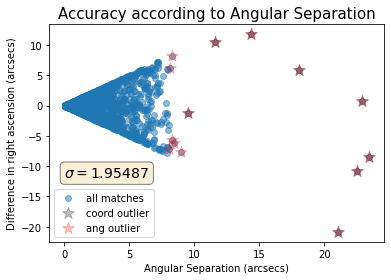

In [84]:
# plot separation in right ascention and declination for closest coordinate matches

textstr = ''r'$\sigma=%.5f$' % (sigma_ang_c, )

plt.scatter(cat_mags['angular_sep'].values, cat_mags['ra_comp'].values, alpha = 0.5, label = 'all matches')
plt.scatter(cat_mags_3sigma['angular_sep'].values, cat_mags_3sigma['ra_comp'].values, 150, alpha = 0.25, \
            color = 'k', marker= '*', label = 'coord outlier')
plt.scatter(cat_mags_3sigma_ang['angular_sep'].values, cat_mags_3sigma_ang['ra_comp'].values, 150, alpha = 0.25, \
            color = 'r', marker= '*', label = 'ang outlier')
plt.xlabel('Angular Separation (arcsecs)')
plt.ylabel('Difference in right ascension (arcsecs)')
plt.title('Accuracy according to Angular Separation', fontsize = 15)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0, -10, textstr, fontsize=14, verticalalignment='top', bbox=props)
plt.legend()

In [85]:
# flag 3 sigma outliers for w1 mags:

mu_w1, sigma_w1, sigma_flag = stats_func_1d(cat_mags['w1_diff'].to_numpy(), cat_mags, 1, 'w1_diff')
cat_mags['sigma_3w1'] = np.array(sigma_flag)
cat_mags_3sigmaw1 = cat_mags.loc[cat_mags['sigma_3w1']==True]
len(cat_mags_3sigmaw1)

56

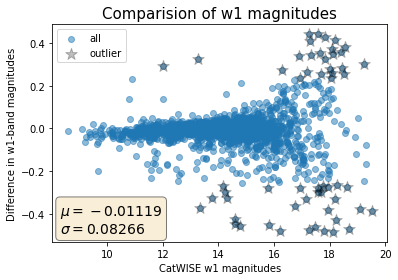

In [86]:
# compare w1-band magnitudes from allwise with catwise

y = cat_mags['w1_comp']
x = cat_mags['w1mpro']

textstr = '\n'.join((
    r'$\mu=%.5f$' % (mu_w1, ),
    r'$\sigma=%.5f$' % (sigma_w1, )))

plt.xlabel('CatWISE w1 magnitudes')
plt.ylabel('Difference in w1-band magnitudes')
plt.title('Comparision of w1 magnitudes', fontsize = 15)
plt.scatter(x, y, alpha = 0.5, label = 'all')
plt.scatter(cat_mags_3sigmaw1['w1mpro'].values, cat_mags_3sigmaw1['w1_diff'].values, 150, alpha = 0.25, \
           color = 'k', marker= '*', label = 'outlier')
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(8.3, -0.35, textstr, fontsize=14, verticalalignment='top', bbox=props)
plt.legend()

In [87]:
# flag 3 sigma outliers for w1 mags:

mu_w2, sigma_w2, sigma_flag = stats_func_1d(cat_mags['w2_diff'].to_numpy(), cat_mags, 1, 'w2_diff')
cat_mags['sigma_3w2'] = np.array(sigma_flag)
cat_mags_3sigmaw2 = cat_mags.loc[cat_mags['sigma_3w2']==True]
len(cat_mags_3sigmaw2)

51

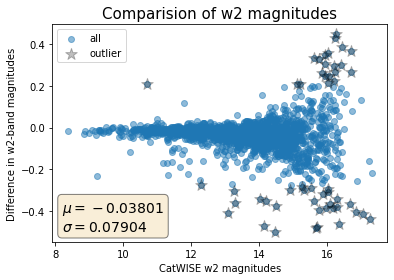

In [88]:
# compare w1-band magnitudes from dupuy with catwise

y = cat_mags['w2_comp']
x = cat_mags['w2mpro']

textstr = '\n'.join((
    r'$\mu=%.5f$' % (mu_w2, ),
    r'$\sigma=%.5f$' % (sigma_w2, )))

plt.xlabel('CatWISE w2 magnitudes')
plt.ylabel('Difference in w2-band magnitudes')
plt.title('Comparision of w2 magnitudes', fontsize = 15)
plt.scatter(x, y, alpha = 0.5, label = 'all')
plt.scatter(cat_mags_3sigmaw2['w2mpro'].values, cat_mags_3sigmaw2['w2_diff'].values, 150, alpha = 0.25, \
           color = 'k', marker= '*', label = 'outlier')
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(8.2, -0.35, textstr, fontsize=14, verticalalignment='top', bbox=props)
plt.legend()

### Photometric Correction of UltracoolSheet to CatWISE2020

The w1-w2 color is calculated from AllWISE photometry from the UltracoolSheet. A linear least squares linear regression is used to find a line of best fit between this color and the difference in W1 and W2 between AllWISE and CatWISE2020. This equation is almost perfectly horizontal, as both AllWISE and CatWISE utilize the WISE instrument and should have consistent photometry across W1 and W2. 

In [89]:
# adding color column

cat_mags['w1_w2_allwise'] = cat_mags['W1'] - cat_mags['W2']
cat_mags['w1_w2_catwise'] = cat_mags['w1mpro'] - cat_mags['w2mpro']

In [90]:
# mask outliers:

correctioncat = cat_mags.loc[cat_mags['sigma_3']==False]   
correctioncat = correctioncat.loc[correctioncat['sigma_3w1']==False]    
correctioncat = correctioncat.loc[correctioncat['sigma_3w2']==False]    
correctioncat = correctioncat.loc[correctioncat['sigma_3ang']==False]   
correctioncat

,ra,dec,w1mpro,w2mpro,w1sigmpro,w2sigmpro,pmra,pmdec,ra_comp,dec_comp,...,Cat_Search,w1_diff,w2_diff,sigma_3,angular_sep,sigma_3ang,sigma_3w1,sigma_3w2,w1_w2_allwise,w1_w2_catwise
0,0.043334,11.601974,16.877,16.869,0.044,0.148,0.03135,-0.01090,-0.233098,-0.09216,...,True,-0.009,-0.256,False,0.250662,False,False,False,0.255,0.008
1,0.301335,15.592465,12.967,12.557,0.012,0.009,0.14627,-0.17977,2.203596,-2.64528,...,True,-0.002,-0.018,False,3.442871,False,False,False,0.426,0.410
2,0.383510,-8.691290,14.354,14.067,0.016,0.016,0.34928,-0.33492,5.018085,-4.64364,...,True,-0.010,-0.074,False,6.836994,False,False,False,0.351,0.287
3,0.712486,24.903770,14.833,14.576,0.016,0.021,0.07238,-0.02756,0.281465,-0.46692,...,True,-0.014,-0.002,False,0.545195,False,False,False,0.245,0.257
4,1.012763,-64.176842,13.405,12.974,0.014,0.010,0.10060,-0.06658,0.098636,-0.15012,...,True,0.004,-0.015,False,0.179614,False,False,False,0.450,0.431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002,359.045483,-34.435950,11.659,11.340,0.012,0.008,0.09938,-0.33788,1.136305,-4.86108,...,True,-0.030,-0.027,False,4.992119,False,False,False,0.316,0.319
2003,359.075358,7.905365,15.650,15.311,0.022,0.039,0.17212,-0.19156,0.918546,-0.84564,...,True,-0.033,0.039,False,1.248530,False,False,False,0.267,0.339
2004,359.318792,12.460781,15.969,14.153,0.029,0.019,0.03453,-0.48802,0.323749,-2.58948,...,True,-0.227,-0.135,False,2.609640,False,False,False,1.724,1.816
2005,359.675408,0.105863,15.413,15.143,0.021,0.036,0.11342,-0.07621,1.827717,-0.49464,...,True,0.026,0.034,False,1.893466,False,False,False,0.262,0.270


In [91]:
# standard deviation

w1w2_array = correctioncat['w1_w2_allwise'].to_numpy()
w1w2_array = np.asarray(w1w2_array)
sigma_w1w2 = w1w2_array.std()
print(sigma_w1w2)

0.5961474170067066


[5.90668756] [0.00310715]


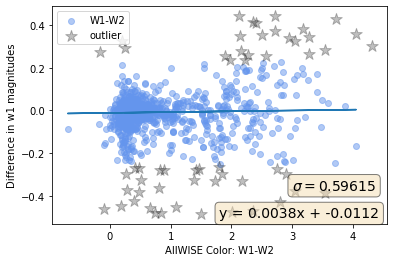

In [92]:
# making the color correction - w1 band

cat_mags_3sigmaw1 = cat_mags.loc[cat_mags['sigma_3w1']==True]

y = correctioncat['w1_comp']
x = correctioncat['w1_w2_allwise']

aw1_final, bw1_final = np.polyfit(x, y, 1)

params, residual, stuff1, stuff2, stuff3 = np.polyfit(x, y, 1, full = True)

w1corr_mse = 1/(len(y)) * residual
print(residual, w1corr_mse)

textstr = 'y = {:.4f}x + {:.4f}'.format(aw1_final, bw1_final)
textstr2 = r'$\sigma=%.5f$' % (sigma_w1w2, )

plt.ylabel('Difference in w1 magnitudes')
plt.xlabel('AllWISE Color: W1-W2')
#plt.title('Photometric Correction of w1 magnitudes', fontsize = 15)
plt.scatter(x, y, alpha = 0.5, color = 'cornflowerblue', label = 'W1-W2')
plt.scatter(cat_mags_3sigmaw1['w1_w2_allwise'], cat_mags_3sigmaw1['w1_comp'], 150, alpha = 0.25, \
           color = 'k', marker= '*', label = 'outlier')
plt.plot(x, aw1_final*x + bw1_final) 
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(1.8, -0.45, textstr, fontsize=14, verticalalignment='top', bbox=props)
plt.text(3, -0.32, textstr2, fontsize=14, verticalalignment='top', bbox=props)
plt.legend()
plt.savefig('w1corr.png')

[5.73932429] [0.00301911]


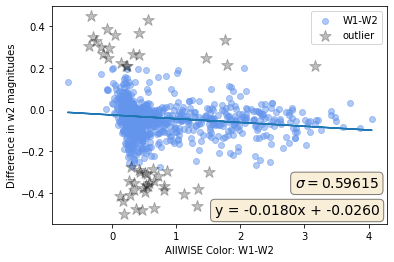

In [93]:
# making the color correction - w2 band

cat_mags_3sigmaw2 = cat_mags.loc[cat_mags['sigma_3w2']==True]

y = correctioncat['w2_comp']
x = correctioncat['w1_w2_allwise']

aw2_final, bw2_final = np.polyfit(x, y, 1)

params, residual, stuff1, stuff2, stuff3 = np.polyfit(x, y, 1, full = True)

w2corr_mse = 1/(len(y)) * residual
print(residual, w2corr_mse)

textstr = 'y = {:.4f}x + {:.4f}'.format(aw2_final, bw2_final)
textstr2 = r'$\sigma=%.5f$' % (sigma_w1w2, )

plt.ylabel('Difference in w2 magnitudes')
plt.xlabel('AllWISE Color: W1-W2')
#plt.title('Photometric Correction of w2 magnitudes', fontsize = 15)
plt.scatter(x, y, alpha = 0.5, color = 'cornflowerblue', label = 'W1-W2')
plt.scatter(cat_mags_3sigmaw2['w1_w2_allwise'], cat_mags_3sigmaw2['w2_comp'], 150, alpha = 0.25, \
           color = 'k', marker= '*', label = 'outlier')
plt.plot(x, aw2_final*x + bw2_final) 
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(1.6, -0.45, textstr, fontsize=14, verticalalignment='top', bbox=props)
plt.text(2.85, -0.32, textstr2, fontsize=14, verticalalignment='top', bbox=props)
plt.legend()
plt.savefig('w2corr.png')

## VISTA Hemisphere Survey

The VISTA Hemisphere Survey contains data in the J, H, and Ks bands (McMahon et al. 2021). Many of the sources in the catalogue lack photometry in the H band, so analysis is focused on the J and Ks bands. The following two quality flags are placed on the J and K bands:

JERRBITS - flags sources with errors in the J band \ 
KSERRBITS - flags sources with errors in the K band \
PSTAR - the probability that a source is a star

to find the overlapping sources between the UltracoolSheet and VISTA. 

In [94]:
# finds all UC Stars with an ra/dec that returns a vista query result

insearch_vista = []
ra_list = []
dec_list = []
radius = 0.007

for i in range(len(ucs)):
    ra0 = ucs.iloc[i, 1] # in degrees, right ascension
    ra_list.append(ra0)
    dec0 = ucs.iloc[i, 2] # in degrees, declinarion
    dec_list.append(dec0)
    query = """
    SELECT ra2000, dec2000, japermag3, ksapermag3
    FROM vhs_dr5.vhs_cat_v3 as vhs,
    q3c_dist(ra2000, dec2000, {:f}, {:f}) as rdist
    WHERE q3c_radial_query(ra2000, dec2000, {:f}, {:f}, {:f})
    AND vhs.jerrbits = 0
    AND vhs.kserrbits = 0
    order by rdist
    """.format(ra0, dec0, ra0, dec0, radius)
    response = qc.query(sql=query,format='csv')
    sources = convert(response,'pandas')
    if len(sources) >= 1:   # need at least one result 
        insearch_vista.append(True)
    else:
        insearch_vista.append(False)


In [95]:
# add true/false search column

ucs['Vista_Search'] = np.array(insearch_vista)

In [96]:
# take only the columns labelled with 'true' to get all potential matches

vista_search = ucs.loc[ucs['Vista_Search']==True]
vista_search = vista_search.reset_index(drop=True)
vista_search

,name,ucs_ra,ucs_dec,ucs_pmra,ucs_pmdec,r_P1,i_P1,z_P1,y_P1,rerr_P1,...,Kserr_2MASS,W1,W2,W1err,W2err,binary,spectral_type,DES_Search,Cat_Search,Vista_Search
0,WISEA J000131.93-084126.9,0.3821,-8.6900,0.33990,-0.30500,NaN,20.21,18.57,17.57,NaN,...,0.090,14.344,13.993,0.031,0.047,N,11.0,False,True,True
1,2MASS J00040288-6410358,1.0127,-64.1768,0.06400,-0.04700,NaN,NaN,NaN,NaN,NaN,...,0.046,13.409,12.959,0.024,0.026,N,11.0,True,True,True
2,WISEA J000430.66-260402.3,1.1278,-26.0666,-0.00100,-0.24400,NaN,NaN,20.12,18.62,NaN,...,NaN,15.211,14.127,0.038,0.044,N,22.0,False,True,True
3,LHS 102BC,1.1453,-40.7351,0.67110,-1.49820,NaN,NaN,NaN,NaN,NaN,...,0.026,10.736,10.463,0.022,0.020,Y: Goli04b,15.0,False,False,True
4,2MASS J00044144-2058298,1.1728,-20.9750,0.75823,0.08520,19.15,16.41,14.94,14.06,0.01,...,0.023,11.056,10.745,0.023,0.020,N,8.0,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
974,SDSS J235835.45-000909.5,359.6478,-0.1526,-0.09700,-0.22900,NaN,21.09,19.55,18.73,NaN,...,NaN,NaN,NaN,NaN,NaN,N,10.0,True,True,True
975,SDSS J235841.98+000622.0,359.6749,0.1060,0.12800,-0.03200,NaN,21.82,20.41,19.54,NaN,...,0.194,15.439,15.177,0.044,0.094,N,11.5,False,True,True
976,APMPM J2359-6246,359.6787,-62.7618,0.59065,0.08356,NaN,NaN,NaN,NaN,NaN,...,0.023,10.305,10.088,0.023,0.020,N,6.0,True,True,True
977,PSO J359.8867-01.8651,359.8868,-1.8647,-0.00600,-0.14600,NaN,NaN,20.32,19.10,NaN,...,0.270,15.263,14.552,0.040,0.058,N,21.0,False,False,True


In [97]:
# takes the 1003 stars from ucs and matches them to vista

vista_query = pd.DataFrame()
no_of_matches = []

for i in range(len(vista_search)):
    ra0 = vista_search.iloc[i, 1]  # in degrees, right ascension
    dec0 = vista_search.iloc[i, 2] # in degrees, declinarion
    js = vista_search.iloc[i, vista_search.columns.get_loc('J_2MASS')]  # j 2mass photometry
    hs = vista_search.iloc[i, vista_search.columns.get_loc('H_2MASS')]  # h 2mass photometry
    ks = vista_search.iloc[i, vista_search.columns.get_loc('Ks_2MASS')] # ks 2mass photometry
    names = vista_search.iloc[i, 0] # unique name of source
    query = """
    SELECT ra2000, dec2000, japermag3, hapermag3, ksapermag3, japermag3err, hapermag3err, ksapermag3err, pstar
    FROM vhs_dr5.vhs_cat_v3 as vhs,
    q3c_dist(ra2000, dec2000, {:f}, {:f}) as rdist
    WHERE q3c_radial_query(ra2000, dec2000, {:f}, {:f}, {:f})
    AND vhs.jerrbits = 0
    AND vhs.kserrbits = 0 
    order by rdist
    """.format(ra0,dec0,ra0,dec0,radius)
    response = qc.query(sql=query,format='csv')
    sources = convert(response,'pandas')
    sources['ra_comp'] = (sources['ra2000'] - ra0) * np.cos(dec0 * (np.pi / 180))  # difference in right ascension
    sources['dec_comp'] = sources['dec2000'] - dec0                                # difference in declination
    sources['j_comp'] = js - sources['japermag3']
    sources['h_comp'] = hs - sources['hapermag3']
    sources['k_comp'] = ks - sources['ksapermag3']
    sources = sources[sources.pstar >= 0.5]
    sources = sources[sources.j_comp.abs() <= 0.5]
    sources = sources[sources.k_comp.abs() <= 0.5]
    closestmatch = sources.copy()
    closestmatch = closestmatch.head(1)
    closestmatch['name'] = names
    no_of_matches.append(len(sources))
    vista_query = pd.concat([vista_query, closestmatch], ignore_index = True)


In [98]:
# print the output

vista_query

,ra2000,dec2000,japermag3,hapermag3,ksapermag3,japermag3err,hapermag3err,ksapermag3err,pstar,ra_comp,dec_comp,j_comp,h_comp,k_comp,name
0,0.383253,-8.691020,15.627021,NaN,14.655676,0.006469,NaN,0.009785,0.999657,0.001140,-0.001020,0.084979,NaN,0.042324,WISEA J000131.93-084126.9
1,1.012635,-64.176816,15.664623,NaN,13.990067,0.005162,NaN,0.005649,0.993865,-0.000028,-0.000016,0.121377,NaN,0.018933,2MASS J00040288-6410358
2,1.127764,-26.067710,16.133543,NaN,15.631360,0.009123,NaN,0.026405,0.999657,-0.000032,-0.001110,0.353457,NaN,-0.108360,WISEA J000430.66-260402.3
3,1.148569,-40.740765,12.979089,NaN,11.389994,0.001049,NaN,0.000994,0.993865,0.002477,-0.005665,0.129911,NaN,0.006006,LHS 102BC
4,1.176529,-20.974553,12.354231,NaN,11.492594,0.000987,NaN,0.001426,0.999657,0.003482,0.000447,0.049769,NaN,-0.096594,2MASS J00044144-2058298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
676,359.647535,-0.153185,17.081957,16.739622,16.227413,0.017197,0.026261,0.028866,0.999657,-0.000265,-0.000585,0.029043,-0.288622,0.441587,SDSS J235835.45-000909.5
677,359.675225,0.105933,17.169792,16.493662,15.884735,0.015772,0.020740,0.019254,0.999657,0.000325,-0.000067,0.002208,0.029338,-0.262735,SDSS J235841.98+000622.0
678,359.683355,-62.761438,11.427283,NaN,10.600347,0.000592,NaN,0.000795,0.993865,0.002131,0.000362,-0.040283,NaN,-0.085347,APMPM J2359-6246
679,359.886718,-1.865039,16.984020,16.305471,15.952973,0.012848,0.017190,0.025049,0.999981,-0.000082,-0.000339,0.256980,-0.275471,0.137027,PSO J359.8867-01.8651


(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   4.,   0., 676.]),
 array([0.734694 , 0.7612227, 0.7877514, 0.8142801, 0.8408088, 0.8673375,
        0.8938662, 0.9203949, 0.9469236, 0.9734523, 0.999981 ]),
 <BarContainer object of 10 artists>)

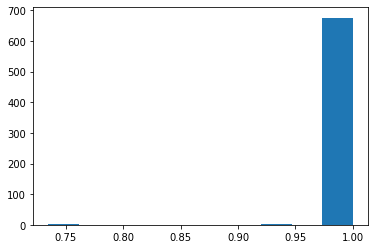

In [99]:
# checking the probabilities of the source being a star

plt.hist(vista_query['pstar'])

In [100]:
# align dataframe with information from ultracool sheet
vista_mags = pd.merge(vista_query, vista_search, how = 'inner', on = 'name')

# add color columns
vista_mags['J_K_2MASS'] = vista_mags['J_2MASS'] - vista_mags['Ks_2MASS']
vista_mags['J_K_vista'] = vista_mags['japermag3'] - vista_mags['ksapermag3']
vista_mags

,ra2000,dec2000,japermag3,hapermag3,ksapermag3,japermag3err,hapermag3err,ksapermag3err,pstar,ra_comp,...,W2,W1err,W2err,binary,spectral_type,DES_Search,Cat_Search,Vista_Search,J_K_2MASS,J_K_vista
0,0.383253,-8.691020,15.627021,NaN,14.655676,0.006469,NaN,0.009785,0.999657,0.001140,...,13.993,0.031,0.047,N,11.0,False,True,True,1.014,0.971345
1,1.012635,-64.176816,15.664623,NaN,13.990067,0.005162,NaN,0.005649,0.993865,-0.000028,...,12.959,0.024,0.026,N,11.0,True,True,True,1.777,1.674556
2,1.127764,-26.067710,16.133543,NaN,15.631360,0.009123,NaN,0.026405,0.999657,-0.000032,...,14.127,0.038,0.044,N,22.0,False,True,True,0.964,0.502183
3,1.148569,-40.740765,12.979089,NaN,11.389994,0.001049,NaN,0.000994,0.993865,0.002477,...,10.463,0.022,0.020,Y: Goli04b,15.0,False,False,True,1.713,1.589095
4,1.176529,-20.974553,12.354231,NaN,11.492594,0.000987,NaN,0.001426,0.999657,0.003482,...,10.745,0.023,0.020,N,8.0,False,True,True,1.008,0.861637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
676,359.647535,-0.153185,17.081957,16.739622,16.227413,0.017197,0.026261,0.028866,0.999657,-0.000265,...,NaN,NaN,NaN,N,10.0,True,True,True,0.442,0.854544
677,359.675225,0.105933,17.169792,16.493662,15.884735,0.015772,0.020740,0.019254,0.999657,0.000325,...,15.177,0.044,0.094,N,11.5,False,True,True,1.550,1.285057
678,359.683355,-62.761438,11.427283,NaN,10.600347,0.000592,NaN,0.000795,0.993865,0.002131,...,10.088,0.023,0.020,N,6.0,True,True,True,0.872,0.826936
679,359.886718,-1.865039,16.984020,16.305471,15.952973,0.012848,0.017190,0.025049,0.999981,-0.000082,...,14.552,0.040,0.058,N,21.0,False,False,True,1.151,1.031047


In [101]:
# converting to arc seconds

vista_mags['dec_comp'] = vista_mags['dec_comp'].apply(lambda x: x*3600)
vista_mags['ra_comp'] = vista_mags['ra_comp'].apply(lambda x: x*3600)

In [102]:
# find high proper motion objects
highpmra_vhs = vista_mags.reindex(vista_mags.ucs_pmra.abs().sort_values(ascending = False).index).head(20)
highpmdec_vhs = vista_mags.reindex(vista_mags.ucs_pmdec.abs().sort_values(ascending = False).index).head(20)

# find binaries
binaries_vhs = vista_mags[vista_mags.binary != 'N']

In [103]:
# flag 3 sigma outliers

sigma_init_v = sigma_2d(vista_mags['ra_comp'].to_numpy(), vista_mags['dec_comp'].to_numpy())
sigma_pos_v, sigma_flag = stats_func_2d(vista_mags['ra_comp'].to_numpy(), vista_mags['dec_comp'].to_numpy(), \
                                        vista_mags, 15, 'ra_comp', 'dec_comp')
vista_mags['sigma_3'] = np.array(sigma_flag)
vista_mags_3sigma = vista_mags.loc[vista_mags['sigma_3']==True]
len(vista_mags_3sigma)

17

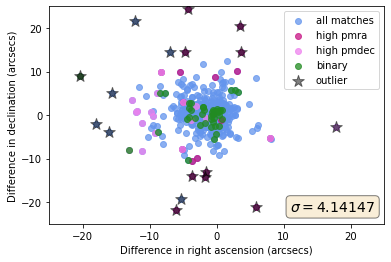

In [104]:
# plot the separation

textstr = ''r'$\sigma=%.5f$' % (sigma_pos_v, )

plt.scatter(vista_mags['dec_comp'].values, vista_mags['ra_comp'].values, alpha = 0.75, color = 'cornflowerblue', label = 'all matches')
plt.scatter(highpmra_vhs['dec_comp'].values, highpmra_vhs['ra_comp'].values, alpha = 0.75, color = 'mediumvioletred', label = 'high pmra')
plt.scatter(highpmdec_vhs['dec_comp'].values, highpmdec_vhs['ra_comp'].values, alpha = 0.75, color = 'violet', label = 'high pmdec')
plt.scatter(binaries_vhs['dec_comp'].values, binaries_vhs['ra_comp'].values, alpha = 0.75, color = 'forestgreen', label = 'binary')
plt.scatter(vista_mags_3sigma['dec_comp'].values, vista_mags_3sigma['ra_comp'].values, 150, alpha = 0.5, \
           color = 'k', marker= '*', label = 'outlier')
plt.ylabel('Difference in declination (arcsecs)')
plt.xlabel('Difference in right ascension (arcsecs)')
#plt.title('Accuracy according to Coordinates (VISTA)', fontsize = 15)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(11, -19.5, textstr, fontsize=14, verticalalignment='top', bbox=props)
plt.xlim(-25, 25)
plt.ylim(-25, 25)
plt.legend()
plt.savefig('cooreaccuracyvhs.png')

In [105]:
# need to convert to radians from degrees (1" × π/(180))
vista_mags['ra2000'] = vista_mags['ra2000'].apply(lambda x: x * (np.pi/180))
vista_mags['dec2000'] = vista_mags['dec2000'].apply(lambda x: x * (np.pi/180))
vista_mags['ucs_ra'] = vista_mags['ucs_ra'].apply(lambda x: x * (np.pi/180))
vista_mags['ucs_dec'] = vista_mags['ucs_dec'].apply(lambda x: x * (np.pi/180))

In [106]:
# calculate radial and angular separation

ang_dis_list = []

for i in range(len(vista_mags)):
    ra_vista = vista_mags.iloc[i, 0]     # in radians, right ascension of VISTA
    dec_vista = vista_mags.iloc[i, 1]    # in radians, declinarion of VISTA
    ra_ucs = vista_mags.iloc[i, vista_mags.columns.get_loc('ucs_ra')]      # in radians, right ascension of UCS
    dec_ucs = vista_mags.iloc[i, vista_mags.columns.get_loc('ucs_dec')]    # in radians, declinarion of UCS
    ang_dis = np.arccos(np.sin(dec_ucs)*np.sin(dec_vista) + np.cos(dec_ucs)*np.cos(dec_vista)*np.cos(ra_ucs - ra_vista))
    ang_dis_list.append(ang_dis)

vista_mags['angular_sep'] = np.array(ang_dis_list)

# convert ra and dec from radians back to degrees
vista_mags['ucs_dec'] = vista_mags['ucs_dec'].apply(lambda x: x * (180/ np.pi))
vista_mags['ucs_ra'] = vista_mags['ucs_ra'].apply(lambda x: x * (180/ np.pi))
vista_mags['dec2000'] = vista_mags['dec2000'].apply(lambda x: x * (180/ np.pi))
vista_mags['ra2000'] = vista_mags['ra2000'].apply(lambda x: x * (180/ np.pi))

In [107]:
# convert angular separation to arcseconds
vista_mags['angular_sep'] = vista_mags['angular_sep'].apply(lambda x: x * (648000/np.pi))


In [108]:
# flag 3 sigma outliers for angular separation:

mu_ang_v, sigma_ang_v, sigma_flag = stats_func_1d(vista_mags['angular_sep'].to_numpy(), vista_mags, 12, 'angular_sep')
vista_mags['sigma_3ang'] = np.array(sigma_flag)
vista_mags_3sigma = vista_mags.loc[vista_mags['sigma_3']==True]
vista_mags_3sigma_ang = vista_mags.loc[vista_mags['sigma_3ang']==True]
print(len(vista_mags_3sigma), len(vista_mags_3sigma_ang))

17 33


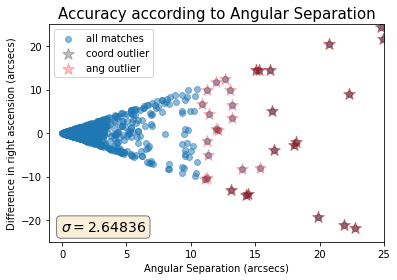

In [109]:
# plot separation in right ascention and declination for closest coordinate matches

textstr = ''r'$\sigma=%.5f$' % (sigma_ang_v, )

plt.scatter(vista_mags['angular_sep'].values, vista_mags['ra_comp'].values, alpha = 0.5, label = 'all matches')
plt.scatter(vista_mags_3sigma['angular_sep'].values, vista_mags_3sigma['ra_comp'].values, 150, alpha = 0.25, \
            color = 'k', marker= '*', label = 'coord outlier')
plt.scatter(vista_mags_3sigma_ang['angular_sep'].values, vista_mags_3sigma_ang['ra_comp'].values, 150, alpha = 0.25, \
            color = 'r', marker= '*', label = 'ang outlier')
plt.xlabel('Angular Separation (arcsecs)')
plt.ylabel('Difference in right ascension (arcsecs)')
plt.title('Accuracy according to Angular Separation', fontsize = 15)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(-0.1, -20, textstr, fontsize=14, verticalalignment='top', bbox=props)
plt.xlim(-1, 25)
plt.ylim(-25, 25)
plt.legend()

In [110]:
# flag 3 sigma outliers for j mags:

mu_j, sigma_j, sigma_flag = stats_func_1d(vista_mags['j_comp'].to_numpy(), vista_mags, 1, 'j_comp')
vista_mags['sigma_3j'] = np.array(sigma_flag)
vista_mags_3sigmaj = vista_mags.loc[vista_mags['sigma_3j']==True]
len(vista_mags_3sigmaj)

11

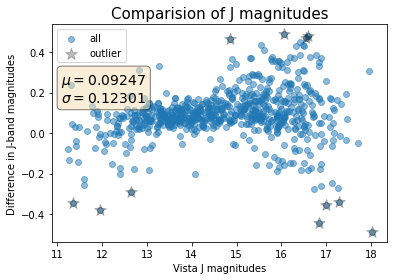

In [114]:
# compare j-band magnitudes from ucs with vista

y = vista_mags['j_comp']
x = vista_mags['japermag3']

textstr = '\n'.join((
    r'$\mu=%.5f$' % (mu_j, ),
    r'$\sigma=%.5f$' % (sigma_j, )))

plt.xlabel('Vista J magnitudes')
plt.ylabel('Difference in J-band magnitudes')
plt.title('Comparision of J magnitudes', fontsize = 15)
plt.scatter(x, y, alpha = 0.5, label = 'all')
plt.scatter(vista_mags_3sigmaj['japermag3'].values, vista_mags_3sigmaj['j_comp'].values, 150, alpha = 0.25, \
           color = 'k', marker= '*', label = 'outlier')
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(11.1, 0.3, textstr, fontsize=14, verticalalignment='top', bbox=props)
plt.legend()

In [115]:
# flag 3 sigma outliers for j mags:

mu_h, sigma_h, sigma_flag = stats_func_1d(vista_mags['h_comp'].to_numpy(), vista_mags, 1, 'h_comp')
vista_mags['sigma_3h'] = np.array(sigma_flag)
vista_mags_3sigmah = vista_mags.loc[vista_mags['sigma_3h']==True]
len(vista_mags_3sigmah)

3

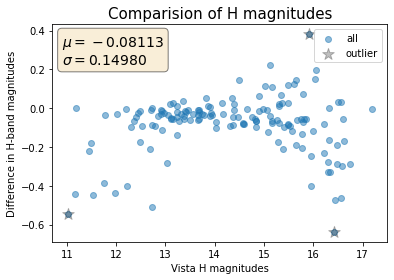

In [119]:
# compare j-band magnitudes from ucs with vista

y = vista_mags['h_comp']
x = vista_mags['hapermag3']

textstr = '\n'.join((
    r'$\mu=%.5f$' % (mu_h, ),
    r'$\sigma=%.5f$' % (sigma_h, )))

plt.xlabel('Vista H magnitudes')
plt.ylabel('Difference in H-band magnitudes')
plt.title('Comparision of H magnitudes', fontsize = 15)
plt.scatter(x, y, alpha = 0.5, label = 'all')
plt.scatter(vista_mags_3sigmah['hapermag3'].values, vista_mags_3sigmah['h_comp'].values, 150, alpha = 0.25, \
           color = 'k', marker= '*', label = 'outlier')
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(10.9, 0.38, textstr, fontsize=14, verticalalignment='top', bbox=props)
plt.legend()

In [120]:
# flag 3 sigma outliers for j mags:

mu_k, sigma_k, sigma_flag = stats_func_1d(vista_mags['k_comp'].to_numpy(), vista_mags, 1, 'k_comp')
vista_mags['sigma_3k'] = np.array(sigma_flag)
vista_mags_3sigmak = vista_mags.loc[vista_mags['sigma_3k']==True]
len(vista_mags_3sigmak)

11

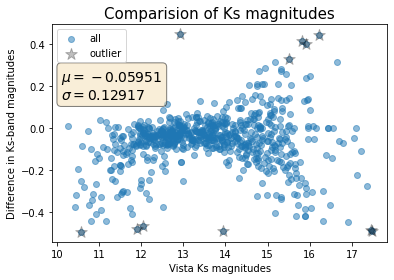

In [121]:
# compare ks-band magnitudes from ucs with vista

y = vista_mags['k_comp']
x = vista_mags['ksapermag3']

textstr = '\n'.join((
    r'$\mu=%.5f$' % (mu_k, ),
    r'$\sigma=%.5f$' % (sigma_k, )))

plt.xlabel('Vista Ks magnitudes')
plt.ylabel('Difference in Ks-band magnitudes')
plt.title('Comparision of Ks magnitudes', fontsize = 15)
plt.scatter(x, y, alpha = 0.5, label = 'all')
plt.scatter(vista_mags_3sigmak['ksapermag3'].values, vista_mags_3sigmak['k_comp'].values, 150, alpha = 0.25, \
           color = 'k', marker= '*', label = 'outlier')
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(10.1, 0.28, textstr, fontsize=14, verticalalignment='top', bbox=props)
plt.legend()

In [122]:
# mask outliers:

correctionvista = vista_mags.loc[vista_mags['sigma_3']==False]    
correctionvista = correctionvista.loc[correctionvista['sigma_3h']==False] 
correctionvista = correctionvista.loc[correctionvista['sigma_3j']==False]   
correctionvista = correctionvista.loc[correctionvista['sigma_3k']==False]   
correctionvista = correctionvista.loc[correctionvista['sigma_3ang']==False]   
correctionvista = correctionvista.reset_index(drop = True)
correctionvista

,ra2000,dec2000,japermag3,hapermag3,ksapermag3,japermag3err,hapermag3err,ksapermag3err,pstar,ra_comp,...,Cat_Search,Vista_Search,J_K_2MASS,J_K_vista,sigma_3,angular_sep,sigma_3ang,sigma_3j,sigma_3h,sigma_3k
0,0.383253,-8.691020,15.627021,NaN,14.655676,0.006469,NaN,0.009785,0.999657,4.104088,...,True,True,1.014,0.971345,False,5.506140,False,False,False,False
1,1.012635,-64.176816,15.664623,NaN,13.990067,0.005162,NaN,0.005649,0.993865,-0.102359,...,True,True,1.777,1.674556,False,0.118003,False,False,False,False
2,1.127764,-26.067710,16.133543,NaN,15.631360,0.009123,NaN,0.026405,0.999657,-0.116139,...,True,True,0.964,0.502183,False,3.997529,False,False,False,False
3,1.742308,-64.615326,13.275948,NaN,12.163472,0.001580,NaN,0.001751,0.993865,1.400940,...,True,True,1.216,1.112476,False,1.619540,False,False,False,False
4,1.783835,-24.968135,13.055741,NaN,12.084828,0.001169,NaN,0.001647,0.999657,3.050032,...,True,True,1.055,0.970913,False,3.164744,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
623,358.593027,-8.191615,17.083893,NaN,14.927217,0.014772,NaN,0.009681,0.999657,1.165357,...,True,True,2.465,2.156676,False,1.398660,False,False,False,False
624,359.226251,-15.889037,15.557752,NaN,15.566377,0.004861,NaN,0.017025,0.999657,-6.747815,...,True,True,0.053,-0.008625,False,10.507265,False,False,False,False
625,359.675225,0.105933,17.169792,16.493662,15.884735,0.015772,0.02074,0.019254,0.999657,1.168728,...,True,True,1.550,1.285057,False,1.193034,False,False,False,False
626,359.683355,-62.761438,11.427283,NaN,10.600347,0.000592,NaN,0.000795,0.993865,7.670066,...,True,True,0.872,0.826936,False,7.780011,False,False,False,False


In [123]:
# standard deviation

jk_array = correctionvista['J_K_2MASS'].to_numpy()
sigma_jk = jk_array.std()
j_array = correctionvista['j_comp'].to_numpy()
sigma_j_diff = j_array.std()
sigma_jcomp = np.sqrt(sigma_jk**2 + sigma_j_diff**2)

[7.35826269] [0.01171698]


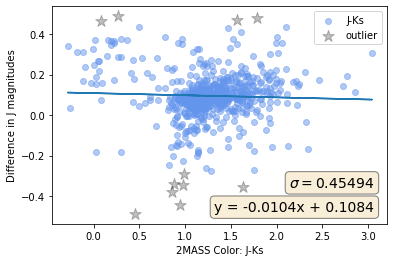

In [124]:
# correction in j

vista_mags_3sigmaj = vista_mags.loc[vista_mags['sigma_3j']==True]

x = correctionvista['J_K_2MASS']
y = correctionvista['j_comp']

aj_final, bj_final = np.polyfit(x, y, 1)

params, residual, stuff1, stuff2, stuff3 = np.polyfit(x, y, 1, full = True)

jcorr_mse = 1/(len(y)) * residual
print(residual, jcorr_mse)

textstr = ''r'$\sigma=%.5f$' % (sigma_jcomp, )
textstr2 = 'y = {:.4f}x + {:.4f}'.format(aj_final, bj_final)

plt.ylabel('Difference in J magnitudes')
plt.xlabel('2MASS Color: J-Ks')
#plt.title('Photometric Correction of J magnitudes', fontsize = 15)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.scatter(x, y, alpha = 0.5, color = 'cornflowerblue', label = 'J-Ks')
plt.scatter(vista_mags_3sigmaj['J_K_2MASS'].values, vista_mags_3sigmaj['j_comp'].values, 150, alpha = 0.25, \
           color = 'k', marker= '*', label = 'outlier')
plt.plot(x, aj_final*x + bj_final) 
plt.text(2.14, -0.3, textstr, fontsize=14, verticalalignment='top', bbox=props)
plt.text(1.32, -0.42, textstr2, fontsize=14, verticalalignment='top', bbox=props)
plt.legend()
plt.savefig('jcorr.png')

In [125]:
# standard deviation

hdiff_array = correctionvista['h_comp'].to_numpy()
sigma_hdiff = hdiff_array.std()
sigma_hcomp = np.sqrt(sigma_jk**2 + sigma_hdiff**2)

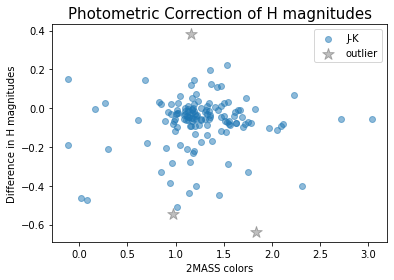

In [126]:
# correction in h

vista_mags_3sigmah = vista_mags.loc[vista_mags['sigma_3h']==True]

x = correctionvista['J_K_2MASS']
y = correctionvista['h_comp']

ah_final, bh_final = np.polyfit(x, y, 1)

textstr = ''r'$\sigma=%.5f$' % (sigma_hcomp, )
textstr2 = 'y = {:.4f}x + {:.4f}'.format(ah_final, bh_final)

plt.ylabel('Difference in H magnitudes')
plt.xlabel('2MASS colors')
plt.title('Photometric Correction of H magnitudes', fontsize = 15)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

plt.scatter(x, y, alpha = 0.5, label = 'J-K')
plt.scatter(vista_mags_3sigmah['J_K_2MASS'].values, vista_mags_3sigmah['h_comp'].values, 150, alpha = 0.25, \
           color = 'k', marker= '*', label = 'outlier')
plt.plot(x, ah_final*x + bh_final) 
#plt.text(2.24, -0.32, textstr, fontsize=14, verticalalignment='top', bbox=props)
#plt.text(1.45, -0.42, textstr2, fontsize=14, verticalalignment='top', bbox=props)
plt.legend()

In [127]:
# standard deviation

kdiff_array = correctionvista['k_comp'].to_numpy()
sigma_kdiff = kdiff_array.std()
sigma_kcomp = np.sqrt(sigma_jk**2 + sigma_kdiff**2)

[7.66740549] [0.01220924]


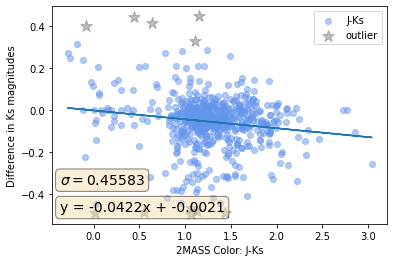

In [128]:
# correction in K

vista_mags_3sigmak = vista_mags.loc[vista_mags['sigma_3k']==True]

x = correctionvista['J_K_2MASS']
y = correctionvista['k_comp']

ak_final, bk_final = np.polyfit(x, y, 1)
params, residual, stuff1, stuff2, stuff3 = np.polyfit(x, y, 1, full = True)

kcorr_mse = 1/(len(y)) * residual
print(residual, kcorr_mse)

textstr = ''r'$\sigma=%.5f$' % (sigma_kcomp, )
textstr2 = 'y = {:.4f}x + {:.4f}'.format(ak_final, bk_final)

plt.ylabel('Difference in Ks magnitudes')
plt.xlabel('2MASS Color: J-Ks')
#plt.title('Photometric Correction of Ks magnitudes', fontsize = 15)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.scatter(x, y, alpha = 0.5, color = 'cornflowerblue', label = 'J-Ks')
plt.scatter(vista_mags_3sigmak['J_K_2MASS'].values, vista_mags_3sigmak['k_comp'].values, 150, alpha = 0.25, \
           color = 'k', marker= '*', label = 'outlier')
plt.plot(x, ak_final*x + bk_final) 
plt.text(-0.37, -0.3, textstr, fontsize=14, verticalalignment='top', bbox=props)
plt.text(-0.37, -0.43, textstr2, fontsize=14, verticalalignment='top', bbox=props)
plt.legend()
plt.savefig('kscorr.png')


## Applying Photometric Correction to Ultracool Sheet

In [232]:
# pull columns required for future RF analysis

sample = ultracoolsheet[['ra_j2000_formula', 'dec_j2000_formula', 'sptnumabs_formula', 'r_P1', 'i_P1', 'z_P1', \
                         'y_P1', 'rerr_P1', 'ierr_P1', 'zerr_P1', 'yerr_P1', 'J_2MASS', 'Ks_2MASS', 'Jerr_2MASS', \
                         'Kserr_2MASS', 'W1', 'W2', 'W1err', 'W2err', 'pmra_formula', 'pmdec_formula']].copy()
sample = sample.rename(columns  = {'ra_j2000_formula' : 'ucs_ra', 'dec_j2000_formula' : 'ucs_dec', \
                                   'pmra_formula' : 'ucs_pmra', 'pmdec_formula' : 'ucs_pmdec', \
                                   'sptnumabs_formula' : 'spectral_type'})
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2940 entries, 0 to 2939
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ucs_ra         2940 non-null   float64
 1   ucs_dec        2940 non-null   float64
 2   spectral_type  2912 non-null   float64
 3   r_P1           940 non-null    float64
 4   i_P1           1645 non-null   float64
 5   z_P1           2059 non-null   float64
 6   y_P1           2177 non-null   float64
 7   rerr_P1        940 non-null    float64
 8   ierr_P1        1645 non-null   float64
 9   zerr_P1        2059 non-null   float64
 10  yerr_P1        2177 non-null   float64
 11  J_2MASS        2274 non-null   float64
 12  Ks_2MASS       2282 non-null   float64
 13  Jerr_2MASS     2241 non-null   float64
 14  Kserr_2MASS    2126 non-null   float64
 15  W1             2644 non-null   float64
 16  W2             2644 non-null   float64
 17  W1err          2608 non-null   float64
 18  W2err   

In [234]:
# add color columns

sample['r_i_P1'] = sample['r_P1'] - sample['i_P1']
sample['i_z_P1'] = sample['i_P1'] - sample['z_P1']
sample['z_y_P1'] = sample['z_P1'] - sample['y_P1']
sample['J_Ks_2MASS'] = sample['J_2MASS'] - sample['Ks_2MASS']
sample['w1_w2_all'] = sample['W1'] - sample['W2']

In [235]:
# photometric correction of sample

sample['DES_r'] = sample['r_P1'] - (ar_final * sample['r_i_P1']) - br_final
sample['DES_i'] = sample['i_P1'] - (ai_final * sample['i_z_P1']) - bi_final
sample['DES_z'] = sample['z_P1'] - (az_final * sample['z_y_P1']) - bz_final
sample['DES_y'] = sample['y_P1'] - (ay_final * sample['z_y_P1']) - by_final
sample['VISTA_J'] = sample['J_2MASS'] - (aj_final * sample['J_Ks_2MASS']) - bj_final
sample['VISTA_Ks'] = sample['Ks_2MASS'] - (ak_final * sample['J_Ks_2MASS']) - bk_final
sample['CAT_W1'] = sample['W1'] - (aw1_final * sample['w1_w2_all']) - bw1_final
sample['CAT_W2'] = sample['W2'] - (aw2_final * sample['w1_w2_all']) - bw2_final
sample

,ucs_ra,ucs_dec,spectral_type,r_P1,i_P1,z_P1,y_P1,rerr_P1,ierr_P1,zerr_P1,...,J_Ks_2MASS,w1_w2_all,DES_r,DES_i,DES_z,DES_y,VISTA_J,VISTA_Ks,CAT_W1,CAT_W2
0,0.0434,11.6020,21.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.255,NaN,NaN,NaN,NaN,NaN,NaN,16.878279,16.643610
1,0.0563,25.9055,24.5,NaN,NaN,19.17,17.42,NaN,NaN,0.01,...,0.227,NaN,NaN,NaN,18.215610,17.277765,14.956989,14.847686,NaN,NaN
2,0.3007,15.5932,13.7,NaN,20.37,18.85,17.81,NaN,0.01,0.02,...,1.812,0.426,NaN,19.869041,18.276015,17.717456,15.432549,13.788503,12.974630,12.572687
3,0.3821,-8.6900,11.0,NaN,20.21,18.57,17.57,NaN,0.03,0.01,...,1.014,0.351,NaN,19.646879,18.017447,17.480256,15.614212,14.742863,14.353915,14.025337
4,0.7124,24.9039,15.5,NaN,22.30,20.30,19.31,NaN,0.08,0.04,...,1.509,0.245,NaN,21.550391,19.752805,19.220955,17.072384,15.721730,14.829317,14.604430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2935,359.6749,0.1060,11.5,NaN,21.82,20.41,19.54,NaN,0.02,0.07,...,1.550,0.262,NaN,21.376024,19.927098,19.459354,17.079812,15.689458,15.449253,15.207736
2936,359.6787,-62.7618,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.872,0.217,NaN,NaN,NaN,NaN,11.287728,10.553877,10.315423,10.117926
2937,359.8868,-1.8647,21.0,NaN,NaN,20.32,19.10,NaN,NaN,0.05,...,1.151,0.711,NaN,NaN,19.649575,18.994858,17.144643,16.140638,15.271549,14.590816
2938,359.9213,-73.5847,26.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.119,1.925,NaN,NaN,NaN,NaN,16.061861,16.057133,15.266942,13.398663


In [236]:
# save completed photometrically corrected Ultracool Sheet as a csv file

sample.to_csv('corrected_UltracoolSheet.csv', na_rep = np.nan, index = False)

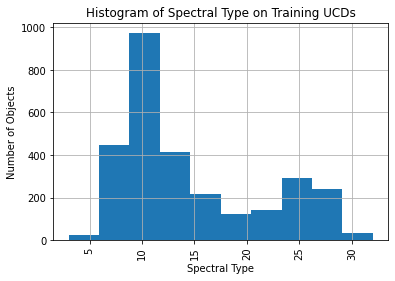

In [133]:
# seeing the range of spectral types available

plt.hist(sample['spectral_type'])
plt.xticks(rotation=90)
plt.xlabel('Spectral Type')
plt.ylabel('Number of Objects')
plt.title('Histogram of Spectral Type on Training UCDs')
plt.grid()

## Search for Contaminant Sample

The initial search for "contaminants" represents a general sky sample from DES DR2, VISTA DR5, and CatWISE2020. The goal of random forests trained using these contaminants is to be able to isolate UCDs from a wide variety of sources seen through these deep surveys. A query is generated based on searching DES for sources near the coordinates of confirmed UCDs using the same quality flags, but with no color cut. The sample is not limited to point-like objects. This sample is matched to VISTA and CatWISE and analyzed to remove poor crossmatches.  

In [135]:
# DES contaminant search

des_contam = pd.DataFrame()
no_of_matches = []
radius = 1

for i in range(len(ucs)):
    ra0 = ucs.iloc[i, 1] # in degrees, right ascension
    dec0 = ucs.iloc[i, 2] # in degrees, declinarion
    query = """
    SELECT ra, dec, wavg_mag_psf_r, wavg_mag_psf_i, wavg_mag_psf_z, wavg_mag_psf_y, wavg_magerr_psf_r, 
    wavg_magerr_psf_i, wavg_magerr_psf_z, wavg_magerr_psf_y
    FROM des_dr2.main as dr2,
    q3c_dist(ra, dec, {:f}, {:f}) as rdist
      WHERE dr2.IMAFLAGS_ISO_I = 0
        AND dr2.IMAFLAGS_ISO_Z = 0
        AND dr2.FLAGS_I < 4 
        AND dr2.FLAGS_Z < 4
        AND q3c_radial_query(ra,dec,{:f},{:f},{:f})
        order by rdist
    """.format(ra0, dec0, ra0, dec0, radius)
    response = qc.query(sql=query,format='csv')
    sources = convert(response,'pandas')
    closestmatch = sources.copy()
    closestmatch = closestmatch.head(15)
    no_of_matches.append(len(sources))
    des_contam = pd.concat([des_contam, closestmatch], ignore_index = True)

des_contam

,ra,dec,wavg_mag_psf_r,wavg_mag_psf_i,wavg_mag_psf_z,wavg_mag_psf_y,wavg_magerr_psf_r,wavg_magerr_psf_i,wavg_magerr_psf_z,wavg_magerr_psf_y,identifier
0,1.012803,-64.176876,22.338305,20.059380,18.519573,17.932535,0.022949,0.005091,0.002203,0.005818,DES6
1,1.008178,-64.176481,23.735090,-99.000000,-99.000000,-99.000000,0.198386,-99.000000,-99.000000,-99.000000,DES6
2,1.007196,-64.174544,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,DES6
3,1.019438,-64.175306,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,DES6
4,1.019821,-64.178571,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,DES6
...,...,...,...,...,...,...,...,...,...,...,...
6490,359.881224,-1.863599,23.330347,22.785057,22.567799,-99.000000,0.058236,0.044940,0.085505,-99.000000,DES2937
6491,359.884799,-1.870127,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,DES2937
6492,359.881361,-1.861646,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,DES2937
6493,359.889457,-1.870342,23.289585,22.998621,22.762957,-99.000000,0.051949,0.056352,0.109566,-99.000000,DES2937


In [142]:
# check for duplicates

duplicated_contam = des_contam[des_contam.duplicated()]
len(duplicated_contam)

29

In [143]:
# drop duplicate rows

des_contam = des_contam.drop_duplicates()
len(des_contam)

6466

In [149]:
# add an identifying index to des contaminant sources

des_contam = des_contam.reset_index(drop = False)
des_contam

,index,ra,dec,wavg_mag_psf_r,wavg_mag_psf_i,wavg_mag_psf_z,wavg_mag_psf_y,wavg_magerr_psf_r,wavg_magerr_psf_i,wavg_magerr_psf_z,wavg_magerr_psf_y
0,0,1.012803,-64.176876,22.338305,20.059380,18.519573,17.932535,0.022949,0.005091,0.002203,0.005818
1,1,1.008178,-64.176481,23.735090,-99.000000,-99.000000,-99.000000,0.198386,-99.000000,-99.000000,-99.000000
2,2,1.007196,-64.174544,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000
3,3,1.019438,-64.175306,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000
4,4,1.019821,-64.178571,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000
...,...,...,...,...,...,...,...,...,...,...,...
6461,6461,359.881224,-1.863599,23.330347,22.785057,22.567799,-99.000000,0.058236,0.044940,0.085505,-99.000000
6462,6462,359.884799,-1.870127,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000
6463,6463,359.881361,-1.861646,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000
6464,6464,359.889457,-1.870342,23.289585,22.998621,22.762957,-99.000000,0.051949,0.056352,0.109566,-99.000000


In [153]:
# remove -99's from the z and y band, replace all other -99's with NaN's

des_contam = des_contam[des_contam.wavg_mag_psf_z != -99] 
des_contam = des_contam[des_contam.wavg_mag_psf_y != -99] 
des_contam = des_contam.replace(-99.0, np.nan)
des_contam = des_contam.reset_index(drop = True)
des_contam = des_contam.rename(columns = {'ra' : 'ra_des', 'dec' : 'dec_des', 'index' : 'identifier'})

des_contam

,identifier,ra_des,dec_des,wavg_mag_psf_r,wavg_mag_psf_i,wavg_mag_psf_z,wavg_mag_psf_y,wavg_magerr_psf_r,wavg_magerr_psf_i,wavg_magerr_psf_z,wavg_magerr_psf_y
0,0,1.012803,-64.176876,22.338305,20.059380,18.519573,17.932535,0.022949,0.005091,0.002203,0.005818
1,6,1.010736,-64.180564,20.584959,20.012016,19.725468,19.662222,0.004596,0.004433,0.005408,0.019350
2,13,1.016998,-64.171474,18.311182,16.967161,16.397903,16.249100,0.001148,0.000610,0.000570,0.001511
3,14,1.026394,-64.176625,18.281527,17.676930,17.378325,17.301603,0.001237,0.001006,0.001072,0.003323
4,20,1.142438,-40.737755,21.997862,21.893202,21.608610,20.910303,0.017408,0.018636,0.029814,0.082331
...,...,...,...,...,...,...,...,...,...,...,...
1407,6436,359.676199,-62.761423,22.110971,21.562525,21.050564,20.603222,0.013111,0.012775,0.020060,0.063340
1408,6438,359.678484,-62.765624,22.700623,21.941673,21.465488,21.210950,0.022763,0.017908,0.023508,0.078088
1409,6445,359.668291,-62.763623,22.093658,21.395561,20.988520,20.937859,0.013313,0.010364,0.015932,0.058899
1410,6446,359.680024,-62.756646,21.907362,20.940449,20.540173,20.387308,0.011931,0.007439,0.010589,0.044417


In [154]:
# match DES contaminants to vista

vista_contam = pd.DataFrame()
no_of_matches = []
radius = 0.007

for i in range(len(des_contam)):
    ra0 = des_contam.iloc[i, des_contam.columns.get_loc('ra_des')]       # in degrees, right ascension
    dec0 = des_contam.iloc[i, des_contam.columns.get_loc('dec_des')]     # in degrees, declinarion
    desid = des_contam.iloc[i, des_contam.columns.get_loc('identifier')] # identifies DES match
    query = """
    SELECT ra2000, dec2000, japermag3, hapermag3, ksapermag3, japermag3err, hapermag3err, ksapermag3err, pstar 
    FROM vhs_dr5.vhs_cat_v3 as vhs,
    q3c_dist(ra2000, dec2000, {:f}, {:f}) as rdist
    WHERE q3c_radial_query(ra2000, dec2000, {:f}, {:f}, {:f}) 
    AND vhs.jerrbits = 0
    AND vhs.kserrbits = 0
    order by rdist
    """.format(ra0, dec0, ra0, dec0, radius)
    response = qc.query(sql=query,format='csv')
    sources = convert(response,'pandas')
    sources['ra_des'] = ra0
    sources['dec_des'] = dec0
    sources['identifier'] = desid
    sources['ra_comp'] = (sources['ra2000'] - ra0) * np.cos(dec0 * (np.pi/180))   # difference in right ascension  
    sources['dec_comp'] = sources['dec2000'] - dec0                               # difference in declination
    sources = sources[sources.pstar >= 0.5]
    closestmatch = sources.copy()
    closestmatch = closestmatch.head(1)
    no_of_matches.append(len(sources))
    vista_contam = pd.concat([vista_contam, closestmatch], ignore_index = True) 

vista_contam

,ra2000,dec2000,japermag3,hapermag3,ksapermag3,japermag3err,hapermag3err,ksapermag3err,pstar,ra_des,dec_des,identifier,ra_comp,dec_comp
0,1.012655,-64.176830,15.672820,NaN,14.057813,0.005674,NaN,0.006040,0.993865,1.012803,-64.176876,0,-0.000065,0.000046
1,1.010676,-64.180531,18.557287,NaN,17.806137,0.051041,NaN,0.164020,0.993865,1.010736,-64.180564,6,-0.000026,0.000033
2,1.016936,-64.171432,14.998213,NaN,14.220320,0.003375,NaN,0.006733,0.993865,1.016998,-64.171474,13,-0.000027,0.000042
3,1.026317,-64.176577,16.135199,NaN,15.403522,0.006939,NaN,0.016329,0.993865,1.026394,-64.176625,14,-0.000034,0.000048
4,1.148569,-40.740765,12.979089,NaN,11.389994,0.001049,NaN,0.000994,0.993865,1.142438,-40.737755,20,0.004646,-0.003010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023,359.683355,-62.761438,11.427283,NaN,10.600347,0.000592,NaN,0.000795,0.993865,359.676199,-62.761423,6436,0.003275,-0.000015
1024,359.683355,-62.761438,11.427283,NaN,10.600347,0.000592,NaN,0.000795,0.993865,359.678484,-62.765624,6438,0.002229,0.004186
1025,359.655443,-62.761784,13.950151,NaN,13.422581,0.001674,NaN,0.003107,0.993865,359.668291,-62.763623,6445,-0.005880,0.001839
1026,359.683411,-62.761428,12.249456,NaN,11.522120,0.000737,NaN,0.001041,0.993865,359.680024,-62.756646,6446,0.001551,-0.004782


In [156]:
# converting to arc seconds

vista_contam['dec_comp'] = vista_contam['dec_comp'].apply(lambda x: x*3600)
vista_contam['ra_comp'] = vista_contam['ra_comp'].apply(lambda x: x*3600)

In [157]:
# flag 3 sigma outliers

sigma_vcon_init = sigma_2d(vista_contam['ra_comp'].to_numpy(), vista_contam['dec_comp'].to_numpy())
sigma_pos_vcon, sigma_flag = stats_func_2d(vista_contam['ra_comp'].to_numpy(), vista_contam['dec_comp'].to_numpy(), \
                                           vista_contam, sigma_vcon_init, 'ra_comp', 'dec_comp')
vista_contam['sigma_3'] = np.array(sigma_flag)
vista_contam_3sigma = vista_contam.loc[vista_contam['sigma_3']==True]
len(vista_contam_3sigma)

52

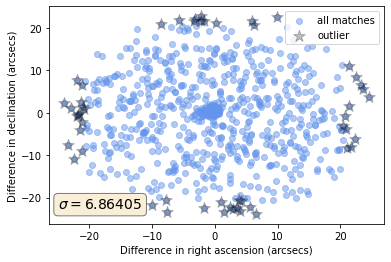

In [158]:
# difference between coordinates of vista and des for contaminants

textstr = ''r'$\sigma=%.5f$' % (sigma_pos_vcon, )

plt.scatter(vista_contam['ra_comp'], vista_contam['dec_comp'], alpha = 0.5, color = 'cornflowerblue', label = 'all matches')
plt.scatter(vista_contam_3sigma['ra_comp'], vista_contam_3sigma['dec_comp'], 150, alpha = 0.25, \
           color = 'k', marker= '*', label = 'outlier')
plt.ylabel('Difference in declination (arcsecs)')
plt.xlabel('Difference in right ascension (arcsecs)')
#plt.title('Accuracy according to Coordinates\n (VISTA-DES Contaminants)', fontsize = 15)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(-25, -20, textstr, fontsize=14, verticalalignment='top', bbox=props)
plt.legend()
plt.savefig('coordaccuracyvistades.png')

In [159]:
# match DES contaminants to catwise

cat_contam = pd.DataFrame()
no_of_matches = []
radius = 0.007

for i in range(len(des_contam)):
    ra0 = des_contam.iloc[i, des_contam.columns.get_loc('ra_des')]       # in degrees, right ascension
    dec0 = des_contam.iloc[i, des_contam.columns.get_loc('dec_des')]     # in degrees, declinarion
    desid = des_contam.iloc[i, des_contam.columns.get_loc('identifier')] # identifies DES match
    query = """
    SELECT ra, dec, w1mpro, w2mpro, w1sigmpro, w2sigmpro, pmra, pmdec
    FROM catwise2020.main,
    q3c_dist(ra, dec, {:f}, {:f}) as rdist
    WHERE cc_flags = '0000'
    AND ab_flags = '00'
    AND q3c_radial_query(ra,dec,{:f},{:f},{:f})
    order by rdist
    """.format(ra0, dec0, ra0, dec0, radius)
    response = qc.query(sql=query,format='csv')
    sources = convert(response,'pandas')
    sources['ra_des'] = ra0
    sources['dec_des'] = dec0
    sources['identifier'] = desid
    sources['ra_comp'] = (sources['ra'] - ra0) * np.cos(dec0 * (np.pi/180))   # difference in right ascension
    sources['dec_comp'] = sources['dec'] - dec0                               # difference in declination
    closestmatch = sources.head(1)
    no_of_matches.append(len(sources))
    cat_contam = pd.concat([cat_contam, closestmatch], ignore_index = True) 

cat_contam

,ra,dec,w1mpro,w2mpro,w1sigmpro,w2sigmpro,pmra,pmdec,ra_des,dec_des,identifier,ra_comp,dec_comp
0,1.012763,-64.176842,13.405,12.974,0.014,0.010,0.10060,-0.06658,1.012803,-64.176876,0,-0.000017,0.000034
1,1.012763,-64.176842,13.405,12.974,0.014,0.010,0.10060,-0.06658,1.010736,-64.180564,6,0.000883,0.003722
2,1.017075,-64.171457,14.140,13.978,0.014,0.013,-0.00140,-0.02549,1.016998,-64.171474,13,0.000033,0.000017
3,1.026409,-64.176622,15.334,15.355,0.019,0.033,0.00641,-0.03581,1.026394,-64.176625,14,0.000007,0.000003
4,1.742238,-64.615317,11.757,11.433,0.013,0.010,0.12270,-0.07331,1.742311,-64.615360,30,-0.000031,0.000043
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1314,359.681186,0.108460,16.463,16.222,0.038,0.095,-0.01042,-0.02283,359.681128,0.108434,6431,0.000058,0.000026
1315,359.671592,0.098534,18.015,17.084,0.124,0.194,-0.29661,-0.23847,359.675930,0.099204,6433,-0.004338,-0.000670
1316,359.683143,-62.761486,11.246,11.054,0.015,0.010,0.65294,0.07641,359.676199,-62.761423,6436,0.003178,-0.000063
1317,359.683143,-62.761486,11.246,11.054,0.015,0.010,0.65294,0.07641,359.678484,-62.765624,6438,0.002132,0.004138


In [160]:
# converting to arc seconds

cat_contam['dec_comp'] = cat_contam['dec_comp'].apply(lambda x: x*3600)
cat_contam['ra_comp'] = cat_contam['ra_comp'].apply(lambda x: x*3600)

In [161]:
# flag 3 sigma outliers

sigma_ccon_init = sigma_2d(cat_contam['ra_comp'].to_numpy(), cat_contam['dec_comp'].to_numpy())
sigma_pos_ccon, sigma_flag = stats_func_2d(cat_contam['ra_comp'].to_numpy(), cat_contam['dec_comp'].to_numpy(), \
                                           cat_contam, sigma_ccon_init, 'ra_comp', 'dec_comp')
cat_contam['sigma_3'] = np.array(sigma_flag)
cat_contam_3sigma = cat_contam.loc[cat_contam['sigma_3']==True]
len(cat_contam_3sigma)

138

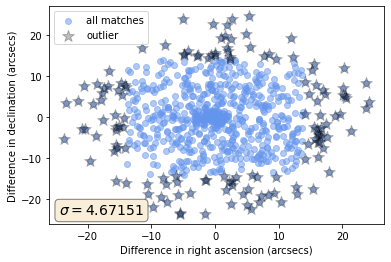

In [163]:
# difference between coordinates of vista and des for contaminants

textstr = ''r'$\sigma=%.5f$' % (sigma_pos_ccon, )

plt.scatter(cat_contam['ra_comp'], cat_contam['dec_comp'], alpha = 0.5, color = 'cornflowerblue', label = 'all matches')
plt.scatter(cat_contam_3sigma['ra_comp'], cat_contam_3sigma['dec_comp'], 150, alpha = 0.25, \
           color = 'k', marker= '*', label = 'outlier')
plt.ylabel('Difference in declination (arcsecs)')
plt.xlabel('Difference in right ascension (arcsecs)')
#plt.title('Accuracy according to Coordinates \n (CatWISE-DES Contaminants)', fontsize = 15)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(-24.5, -21, textstr, fontsize=14, verticalalignment='top', bbox=props)
plt.legend()
plt.savefig('coordaccuracycatdes.png')

In [164]:
print(des_contam['identifier'].nunique(), vista_contam['identifier'].nunique(), cat_contam['identifier'].nunique())

1412 1028 1319


In [165]:
print(len(des_contam), len(vista_contam), len(cat_contam))

1412 1028 1319


In [166]:
# merge the cross-matched sets

contaminants = pd.merge(pd.merge(des_contam, vista_contam, on = 'identifier'), cat_contam, on = 'identifier')
contaminants

,identifier,ra_des_x,dec_des_x,wavg_mag_psf_r,wavg_mag_psf_i,wavg_mag_psf_z,wavg_mag_psf_y,wavg_magerr_psf_r,wavg_magerr_psf_i,wavg_magerr_psf_z,...,w2mpro,w1sigmpro,w2sigmpro,pmra,pmdec,ra_des,dec_des,ra_comp_y,dec_comp_y,sigma_3_y
0,0,1.012803,-64.176876,22.338305,20.059380,18.519573,17.932535,0.022949,0.005091,0.002203,...,12.974,0.014,0.010,0.10060,-0.06658,1.012803,-64.176876,-0.062882,0.12348,False
1,6,1.010736,-64.180564,20.584959,20.012016,19.725468,19.662222,0.004596,0.004433,0.005408,...,12.974,0.014,0.010,0.10060,-0.06658,1.010736,-64.180564,3.178040,13.40028,False
2,13,1.016998,-64.171474,18.311182,16.967161,16.397903,16.249100,0.001148,0.000610,0.000570,...,13.978,0.014,0.013,-0.00140,-0.02549,1.016998,-64.171474,0.120143,0.06084,False
3,14,1.026394,-64.176625,18.281527,17.676930,17.378325,17.301603,0.001237,0.001006,0.001072,...,15.355,0.019,0.033,0.00641,-0.03581,1.026394,-64.176625,0.023836,0.01044,False
4,30,1.742311,-64.615360,19.942392,17.264570,15.659860,15.111554,0.003207,0.000811,0.000423,...,11.433,0.013,0.010,0.12270,-0.07331,1.742311,-64.615360,-0.112969,0.15336,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970,6431,359.681128,0.108434,19.968231,19.614120,19.446733,19.183464,0.002656,0.002948,0.004035,...,16.222,0.038,0.095,-0.01042,-0.02283,359.681128,0.108434,0.209520,0.09504,False
971,6433,359.675930,0.099204,22.132061,21.142113,20.701452,20.600460,0.018449,0.012577,0.014049,...,17.084,0.124,0.194,-0.29661,-0.23847,359.675930,0.099204,-15.617137,-2.41020,True
972,6436,359.676199,-62.761423,22.110971,21.562525,21.050564,20.603222,0.013111,0.012775,0.020060,...,11.054,0.015,0.010,0.65294,0.07641,359.676199,-62.761423,11.441190,-0.22824,False
973,6438,359.678484,-62.765624,22.700623,21.941673,21.465488,21.210950,0.022763,0.017908,0.023508,...,11.054,0.015,0.010,0.65294,0.07641,359.678484,-62.765624,7.675084,14.89536,True


In [167]:
contaminants.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 975 entries, 0 to 974
Data columns (total 38 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   identifier         975 non-null    int64  
 1   ra_des_x           975 non-null    float64
 2   dec_des_x          975 non-null    float64
 3   wavg_mag_psf_r     881 non-null    float64
 4   wavg_mag_psf_i     947 non-null    float64
 5   wavg_mag_psf_z     975 non-null    float64
 6   wavg_mag_psf_y     975 non-null    float64
 7   wavg_magerr_psf_r  881 non-null    float64
 8   wavg_magerr_psf_i  947 non-null    float64
 9   wavg_magerr_psf_z  975 non-null    float64
 10  wavg_magerr_psf_y  975 non-null    float64
 11  ra2000             975 non-null    float64
 12  dec2000            975 non-null    float64
 13  japermag3          975 non-null    float64
 14  hapermag3          474 non-null    float64
 15  ksapermag3         975 non-null    float64
 16  japermag3err       975 non

In [168]:
# get rid of positional outliers

contaminants = contaminants.loc[contaminants['sigma_3_x']==False]
contaminants = contaminants.loc[contaminants['sigma_3_y']==False]
len(contaminants)

838

In [172]:
# drop h-band columns

contaminants = contaminants.drop(columns = ['hapermag3', 'hapermag3err'])

In [171]:
# add color columns to check for outliers

contaminants['z_J'] = contaminants['wavg_mag_psf_z'] - contaminants['japermag3']
contaminants['J_W1'] = contaminants['japermag3'] - contaminants['w1mpro']

In [174]:
# flag 3 sigma outliers for color-color plot:

sigma_concolors_init = sigma_2d(contaminants['z_J'].to_numpy(), contaminants['J_W1'].to_numpy())
sigma_concolors, sigma_flag = stats_func_2d(contaminants['z_J'].to_numpy(), contaminants['J_W1'].to_numpy(), \
                                            contaminants, sigma_concolors_init, 'z_J', 'J_W1')
contaminants['sigma_3zj'] = np.array(sigma_flag)
contaminants_sigma_3zj = contaminants.loc[contaminants['sigma_3zj']==True]
len(contaminants_sigma_3zj)

186

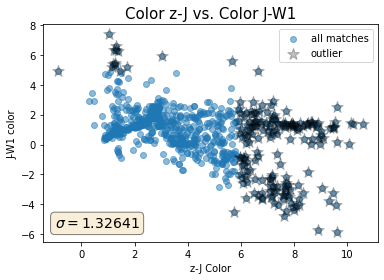

In [177]:
# color-mag plots

textstr = ''r'$\sigma=%.5f$' % (sigma_concolors, )

plt.scatter(contaminants['z_J'], contaminants['J_W1'], alpha = 0.5, label = 'all matches')
plt.scatter(contaminants_sigma_3zj['z_J'], contaminants_sigma_3zj['J_W1'], 150, alpha = 0.25, \
           color = 'k', marker= '*', label = 'outlier')
plt.ylabel('J-W1 color')
plt.xlabel('z-J Color')
plt.title('Color z-J vs. Color J-W1', fontsize = 15)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(-1, -4.8, textstr, fontsize=14, verticalalignment='top', bbox=props)
plt.legend()

In [188]:
# flag 3 sigma outliers for mag-color plot:

sigma_zjz_init = sigma_2d(contaminants['z_J'].to_numpy(), contaminants['wavg_mag_psf_z'].to_numpy())
sigma_zjz, sigma_flag = stats_func_2d(contaminants['z_J'].to_numpy(), contaminants['wavg_mag_psf_z'].to_numpy(), \
                                            contaminants, 23, 'z_J', 'wavg_mag_psf_z')
contaminants['sigma_3zj'] = np.array(sigma_flag)
contaminants_sigma_3zj = contaminants.loc[contaminants['sigma_3zj']==True]
len(contaminants_sigma_3zj)

0

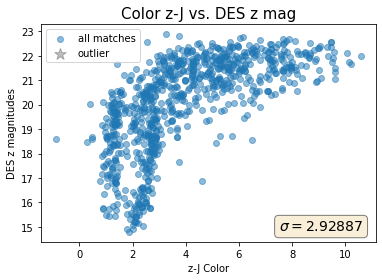

In [190]:
# color-mag plots

textstr = ''r'$\sigma=%.5f$' % (sigma_zjz, )

plt.scatter(contaminants['z_J'], contaminants['wavg_mag_psf_z'], alpha = 0.5, label = 'all matches')
plt.scatter(contaminants_sigma_3zj['z_J'], contaminants_sigma_3zj['wavg_mag_psf_z'], 150, alpha = 0.25, \
           color = 'k', marker= '*', label = 'outlier')
plt.ylabel('DES z magnitudes')
plt.xlabel('z-J Color')
plt.title('Color z-J vs. DES z mag', fontsize = 15)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(7.5, 15.3, textstr, fontsize=14, verticalalignment='top', bbox=props)
plt.legend()

In [194]:
# flag 3 sigma outliers for j mags:
      
sigma_jw1j_init = sigma_2d(contaminants['J_W1'].to_numpy(), contaminants['japermag3'].to_numpy())
sigma_jw1j, sigma_flag = stats_func_2d(contaminants['J_W1'].to_numpy(), contaminants['japermag3'].to_numpy(), \
                                            contaminants, 20, 'z_J', 'japermag3')
contaminants['sigma_3jw1'] = np.array(sigma_flag)
contaminants_sigma_3jw1 = contaminants.loc[contaminants['sigma_3jw1']==True]
len(contaminants_sigma_3jw1)

39

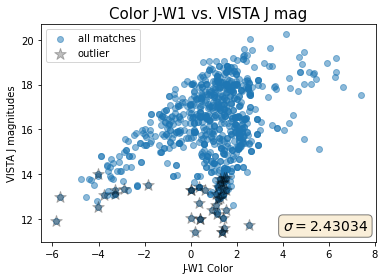

In [196]:
# color-mag plots

textstr = ''r'$\sigma=%.5f$' % (sigma_jw1j, )

plt.scatter(contaminants['J_W1'], contaminants['japermag3'], alpha = 0.5, label = 'all matches')
plt.scatter(contaminants_sigma_3jw1['J_W1'], contaminants_sigma_3jw1['japermag3'], 150, alpha = 0.25, \
           color = 'k', marker= '*', label = 'outlier')
plt.ylabel('VISTA J magnitudes')
plt.xlabel('J-W1 Color')
plt.title('Color J-W1 vs. VISTA J mag', fontsize = 15)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(4, 12, textstr, fontsize=14, verticalalignment='top', bbox=props)
plt.legend()

In [198]:
# create the final contaminant sample by removing outliers

contam_sample = contaminants.copy()
contam_sample = contam_sample.loc[contam_sample['sigma_3zj']==False]
contam_sample = contam_sample.loc[contam_sample['sigma_3jw1']==False]
contam_sample = contam_sample.reset_index(drop = True)
contam_sample

,identifier,ra_des_x,dec_des_x,wavg_mag_psf_r,wavg_mag_psf_i,wavg_mag_psf_z,wavg_mag_psf_y,wavg_magerr_psf_r,wavg_magerr_psf_i,wavg_magerr_psf_z,...,pmdec,ra_des,dec_des,ra_comp_y,dec_comp_y,sigma_3_y,z_J,J_W1,sigma_3zj,sigma_3jw1
0,0,1.012803,-64.176876,22.338305,20.059380,18.519573,17.932535,0.022949,0.005091,0.002203,...,-0.06658,1.012803,-64.176876,-0.062882,0.12348,False,2.846753,2.267820,False,False
1,6,1.010736,-64.180564,20.584959,20.012016,19.725468,19.662222,0.004596,0.004433,0.005408,...,-0.06658,1.010736,-64.180564,3.178040,13.40028,False,1.168181,5.152287,False,False
2,13,1.016998,-64.171474,18.311182,16.967161,16.397903,16.249100,0.001148,0.000610,0.000570,...,-0.02549,1.016998,-64.171474,0.120143,0.06084,False,1.399690,0.858213,False,False
3,14,1.026394,-64.176625,18.281527,17.676930,17.378325,17.301603,0.001237,0.001006,0.001072,...,-0.03581,1.026394,-64.176625,0.023836,0.01044,False,1.243126,0.801199,False,False
4,30,1.742311,-64.615360,19.942392,17.264570,15.659860,15.111554,0.003207,0.000811,0.000423,...,-0.07331,1.742311,-64.615360,-0.112969,0.15336,False,2.383912,1.518948,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794,6375,358.614885,-56.823806,17.659561,17.529726,17.482481,17.494793,0.000871,0.000935,0.001468,...,-0.03915,358.614885,-56.823806,-0.565580,-0.34020,False,0.901596,0.651885,False,False
795,6406,359.647367,-0.153444,23.445010,20.599306,19.107980,18.691925,0.058446,0.009130,0.004068,...,-0.00134,359.647367,-0.153444,-5.867979,-2.88864,False,2.014380,2.153600,False,False
796,6408,359.645726,-0.154269,19.691936,18.155030,17.454308,17.263304,0.002628,0.001197,0.001093,...,-0.00134,359.645726,-0.154269,0.039600,0.08136,False,1.521257,0.993051,False,False
797,6421,359.675413,0.105856,23.716251,21.508831,19.902794,19.386797,0.087076,0.015596,0.006430,...,-0.07621,359.675413,0.105856,-0.019080,0.02376,False,2.733002,1.756792,False,False


In [199]:
# remove unwanted columns

contam_sample = contam_sample.drop(columns=['sigma_3zj', 'sigma_3jw1'])
contam_sample

,identifier,ra_des_x,dec_des_x,wavg_mag_psf_r,wavg_mag_psf_i,wavg_mag_psf_z,wavg_mag_psf_y,wavg_magerr_psf_r,wavg_magerr_psf_i,wavg_magerr_psf_z,...,w2sigmpro,pmra,pmdec,ra_des,dec_des,ra_comp_y,dec_comp_y,sigma_3_y,z_J,J_W1
0,0,1.012803,-64.176876,22.338305,20.059380,18.519573,17.932535,0.022949,0.005091,0.002203,...,0.010,0.10060,-0.06658,1.012803,-64.176876,-0.062882,0.12348,False,2.846753,2.267820
1,6,1.010736,-64.180564,20.584959,20.012016,19.725468,19.662222,0.004596,0.004433,0.005408,...,0.010,0.10060,-0.06658,1.010736,-64.180564,3.178040,13.40028,False,1.168181,5.152287
2,13,1.016998,-64.171474,18.311182,16.967161,16.397903,16.249100,0.001148,0.000610,0.000570,...,0.013,-0.00140,-0.02549,1.016998,-64.171474,0.120143,0.06084,False,1.399690,0.858213
3,14,1.026394,-64.176625,18.281527,17.676930,17.378325,17.301603,0.001237,0.001006,0.001072,...,0.033,0.00641,-0.03581,1.026394,-64.176625,0.023836,0.01044,False,1.243126,0.801199
4,30,1.742311,-64.615360,19.942392,17.264570,15.659860,15.111554,0.003207,0.000811,0.000423,...,0.010,0.12270,-0.07331,1.742311,-64.615360,-0.112969,0.15336,False,2.383912,1.518948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794,6375,358.614885,-56.823806,17.659561,17.529726,17.482481,17.494793,0.000871,0.000935,0.001468,...,0.044,-0.01860,-0.03915,358.614885,-56.823806,-0.565580,-0.34020,False,0.901596,0.651885
795,6406,359.647367,-0.153444,23.445010,20.599306,19.107980,18.691925,0.058446,0.009130,0.004068,...,0.031,0.07081,-0.00134,359.647367,-0.153444,-5.867979,-2.88864,False,2.014380,2.153600
796,6408,359.645726,-0.154269,19.691936,18.155030,17.454308,17.263304,0.002628,0.001197,0.001093,...,0.031,0.07081,-0.00134,359.645726,-0.154269,0.039600,0.08136,False,1.521257,0.993051
797,6421,359.675413,0.105856,23.716251,21.508831,19.902794,19.386797,0.087076,0.015596,0.006430,...,0.036,0.11342,-0.07621,359.675413,0.105856,-0.019080,0.02376,False,2.733002,1.756792


In [237]:
# save contaminant sample as a csv file

contam_sample.to_csv('contaminant_sample.csv', na_rep = np.nan, index = False)

In [ ]:
training1 = sample[['DES_r', 'DES_i', 'DES_z', 'DES_y', 'VISTA_J', 'VISTA_Ks', 'CAT_W1', 'CAT_W2', 'pmra', 'pmdec']].copy()
training1

In [190]:
# adjusting the training data to match the contaminant data labels and units

training1['pmra'] = training1['pmra'].apply(lambda x: x*0.001)
training1['pmdec'] = training1['pmdec'].apply(lambda x: x*0.001)
training1['label'] = 1
training1

,DES_r,DES_i,DES_z,DES_y,VISTA_J,VISTA_Ks,CAT_W1,CAT_W2,pmra,pmdec,label
5,18.902018,16.362285,15.006034,14.597053,12.975326,12.009839,11.713329,11.547267,0.28670,-0.14543,1
9,18.583630,15.934942,14.451741,13.978654,12.311544,11.430377,11.064129,10.775614,0.75823,0.08520,1
12,19.325241,16.660843,15.217814,14.760754,13.181383,12.237934,11.899199,11.653788,0.71080,-0.12481,1
15,22.221409,19.805663,18.261373,17.708156,15.567950,14.069717,13.480158,13.209276,-0.03300,0.01040,1
20,16.957182,14.697692,13.598549,13.301750,11.874868,11.119222,10.892268,10.688981,-0.06100,-0.32135,1
...,...,...,...,...,...,...,...,...,...,...,...
2917,18.729468,16.105663,14.631025,14.147254,12.378064,11.311010,10.959220,10.726544,0.37210,0.19770,1
2919,18.642824,16.123727,14.816750,14.418452,12.747321,11.779918,11.471128,11.181632,0.11100,-0.11470,1
2921,19.172018,16.575303,15.101741,14.628654,12.940314,11.970036,11.623195,11.374844,-0.05020,-0.38319,1
2928,20.617988,18.099402,16.537447,16.000256,14.085220,13.078531,12.581159,12.311257,-0.18150,-0.05190,1


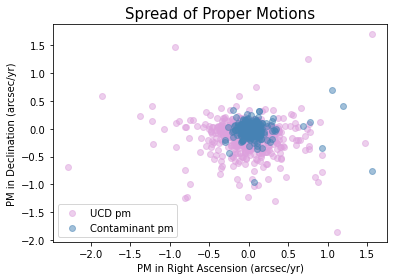

In [191]:
# spread of pmra and pmdec

plt.scatter(training1['pmra'], training1['pmdec'], alpha = 0.5, color = 'plum', label = 'UCD pm')
plt.scatter(contam_sample['pmra'], contam_sample['pmdec'], alpha = 0.5, color = 'steelblue', label = 'Contaminant pm')
plt.legend()
plt.title('Spread of Proper Motions', fontsize = 15)
plt.xlabel('PM in Right Ascension (arcsec/yr)')
plt.ylabel('PM in Declination (arcsec/yr)')
plt.savefig('pmspread.png')

In [192]:
training_vis = training1.copy()
training_vis['z_J'] = training_vis['DES_z'] - training_vis['VISTA_J']
training_vis['J_W1'] = training_vis['VISTA_J'] - training_vis['CAT_W1']
training_vis

,DES_r,DES_i,DES_z,DES_y,VISTA_J,VISTA_Ks,CAT_W1,CAT_W2,pmra,pmdec,label,z_J,J_W1
5,18.902018,16.362285,15.006034,14.597053,12.975326,12.009839,11.713329,11.547267,0.28670,-0.14543,1,2.030708,1.261997
9,18.583630,15.934942,14.451741,13.978654,12.311544,11.430377,11.064129,10.775614,0.75823,0.08520,1,2.140197,1.247415
12,19.325241,16.660843,15.217814,14.760754,13.181383,12.237934,11.899199,11.653788,0.71080,-0.12481,1,2.036431,1.282184
15,22.221409,19.805663,18.261373,17.708156,15.567950,14.069717,13.480158,13.209276,-0.03300,0.01040,1,2.693423,2.087792
20,16.957182,14.697692,13.598549,13.301750,11.874868,11.119222,10.892268,10.688981,-0.06100,-0.32135,1,1.723680,0.982600
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2917,18.729468,16.105663,14.631025,14.147254,12.378064,11.311010,10.959220,10.726544,0.37210,0.19770,1,2.252961,1.418844
2919,18.642824,16.123727,14.816750,14.418452,12.747321,11.779918,11.471128,11.181632,0.11100,-0.11470,1,2.069429,1.276194
2921,19.172018,16.575303,15.101741,14.628654,12.940314,11.970036,11.623195,11.374844,-0.05020,-0.38319,1,2.161427,1.317119
2928,20.617988,18.099402,16.537447,16.000256,14.085220,13.078531,12.581159,12.311257,-0.18150,-0.05190,1,2.452227,1.504060


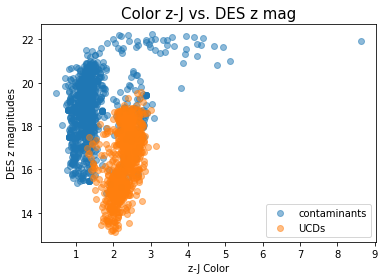

In [193]:
# color-mag plots

#textstr = ''r'$\sigma=%.5f$' % (sigma_ctot, )

plt.scatter(vis_contaminants['z_J'], vis_contaminants['wavg_mag_psf_z'], alpha = 0.5, label = 'contaminants')
plt.scatter(training_vis['z_J'], training_vis['DES_z'], alpha = 0.5, label = 'UCDs')

plt.ylabel('DES z magnitudes')
plt.xlabel('z-J Color')
plt.title('Color z-J vs. DES z mag', fontsize = 15)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#plt.text(4.85, 16.7, textstr, fontsize=14, verticalalignment='top', bbox=props)
plt.legend()

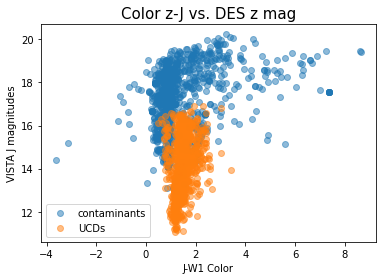

In [194]:
# color-mag plots

#textstr = ''r'$\sigma=%.5f$' % (sigma_ctot, )

plt.scatter(vis_contaminants['J_W1'], vis_contaminants['japermag3'], alpha = 0.5, label = 'contaminants')
plt.scatter(training_vis['J_W1'], training_vis['VISTA_J'], alpha = 0.5, label = 'UCDs')

plt.ylabel('VISTA J magnitudes')
plt.xlabel('J-W1 Color')
plt.title('Color z-J vs. DES z mag', fontsize = 15)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#plt.text(4.85, 16.7, textstr, fontsize=14, verticalalignment='top', bbox=props)
plt.legend()

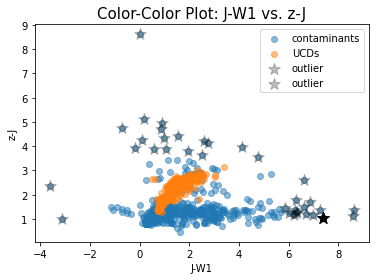

In [195]:
# color-mag plots

#textstr = ''r'$\sigma=%.5f$' % (sigma_ctot, )

plt.scatter(vis_contaminants['J_W1'], vis_contaminants['z_J'], alpha = 0.5, label = 'contaminants')
plt.scatter(training_vis['J_W1'], training_vis['z_J'], alpha = 0.5, label = 'UCDs')
plt.scatter(vis_contaminants_sigma_3jw1['J_W1'], vis_contaminants_sigma_3jw1['z_J'], 150, alpha = 0.25, \
           color = 'k', marker= '*', label = 'outlier')
plt.scatter(vis_contaminants_sigma_3zj['J_W1'], vis_contaminants_sigma_3zj['z_J'], 150, alpha = 0.25, \
           color = 'k', marker= '*', label = 'outlier')
plt.title('Color-Color Plot: J-W1 vs. z-J', fontsize = 15)
plt.xlabel('J-W1')
plt.ylabel('z-J')
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#plt.text(4.85, 16.7, textstr, fontsize=14, verticalalignment='top', bbox=props)
plt.legend()

In [555]:
import h5py

spectraldata = 'spectral_templates_data_version_jul26.h5'
df_singles = pd.read_hdf(spectraldata , key = 'singles')
df_singles

,spectral_type,spex_type,opt_type,name,wavegrid,obs_date,system_interpolated_flux,system_interpolated_noise,difference_spectrum
0,M6.0,M6.0,nan,2MASS J16002535-2644060,"[0.90067, 0.904086, 0.907521, 0.910973, 0.9144...",20120608,"[2.6028127865723416e-10, 2.7168700927281424e-1...","[1.6007560244513144e-12, 1.60595768781994e-12,...","[0.008237880884910731, 0.004852942291611706, 0..."
1,d/sdM6.0,M6.0,nan,2MASS J17252029-0024508,"[0.90067, 0.904086, 0.907521, 0.910973, 0.9144...",20030523,"[2.947453597674446e-10, 2.939515927851977e-10,...","[6.599691322235962e-12, 6.821073308310938e-12,...","[0.09272296992074003, 0.09504443939680107, 0.0..."
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,d/sdM5.0,M6.0,nan,WISE J141143.25-452418.3,"[0.90067, 0.904086, 0.907521, 0.910973, 0.9144...",20140504,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.23088117235440464, 0.213956312675757, 0.197..."
4,d/sdM6.0,M6.0,nan,2MASS J19445221-0831036,"[0.90067, 0.904086, 0.907521, 0.910973, 0.9144...",20030917,"[2.351640075913892e-10, 2.492207188240057e-10,...","[6.246176255121872e-12, 6.1255017124242765e-12...","[0.2418255866251302, 0.20048626167716166, 0.16..."
...,...,...,...,...,...,...,...,...,...
468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
470,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


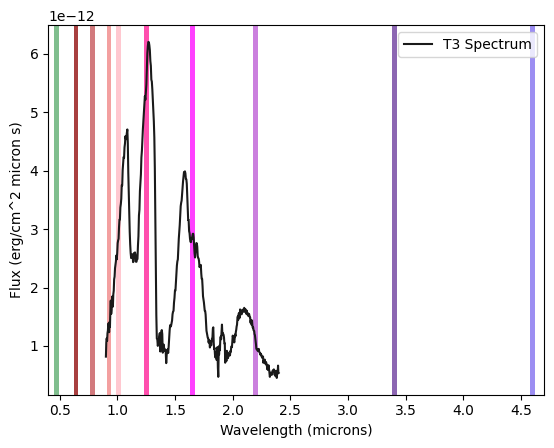

In [596]:
plt.plot(df_singles.iloc[350,4], df_singles.iloc[350,6], color = 'k', label = 'T3 Spectrum')
plt.xlim(0.4, 4.7)
plt.xlabel('Wavelength (microns)')
plt.ylabel('Flux (erg/cm^2 micron s)')
plt.legend()

# for g
plt.axvspan(0.452, 0.492, facecolor='g', alpha=0.75)
# for r
plt.axvspan(0.6215, 0.6615, facecolor='darkred', alpha=0.75)  
# for i
plt.axvspan(0.7635, 0.8035, facecolor='r', alpha=0.75)
# for z
plt.axvspan(0.906, 0.946, facecolor='lightcoral', alpha=0.75)
# for Y
plt.axvspan(0.9895, 1.0295, facecolor='lightpink', alpha=0.75)
# for J
plt.axvspan(1.230, 1.270, facecolor='deeppink', alpha=0.75)
# for H
plt.axvspan(1.630, 1.670, facecolor='magenta', alpha=0.75)
# for Ks
plt.axvspan(2.180, 2.220, facecolor='mediumorchid', alpha=0.75)
# for W1
plt.axvspan(3.380, 3.420, facecolor='rebeccapurple', alpha=0.75)
# for W2
plt.axvspan(4.580, 4.620, facecolor='mediumslateblue', alpha=0.75)

plt.savefig('photometricbands')